# Summary

This notebook is focused on cleaning the Austin housing dataset that was obtained from Zillow.


In [779]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopy.distance
import datetime


In [862]:
# Load Austin Housing Listing
austin_df = pd.read_csv("../../data/austin_housing_data.csv")
austin_df.head(1)


,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...


---

## Cleaning


In [781]:
# Check dataset shape
austin_df.shape


(15171, 47)

In [782]:
def camel_case_to_snake_case(word):
    """Converts camel case to snake case

    Args:
        word (string): Given word needs to be converted to snake case

    Returns:
        string: Snake case version of the word
    """
    return "".join(
        [f"_{letter.lower()}" if letter.isupper() else letter for letter in word]
    )


In [783]:
# Convert columns to snake case
austin_df.columns = [camel_case_to_snake_case(col) for col in austin_df.columns]


In [784]:
austin_df.isna().sum()


zpid                               0
city                               0
street_address                     0
zipcode                            0
description                        0
latitude                           0
longitude                          0
property_tax_rate                  0
garage_spaces                      0
has_association                    0
has_cooling                        0
has_garage                         0
has_heating                        0
has_spa                            0
has_view                           0
home_type                          0
parking_spaces                     0
year_built                         0
latest_price                       0
num_price_changes                  0
latest_saledate                    0
latest_salemonth                   0
latest_saleyear                    0
latest_price_source                0
num_of_photos                      0
num_of_accessibility_features      0
num_of_appliances                  0
n

> No missing data found


In [785]:
# Drop 0 bedrooms and bathrooms
austin_df = austin_df[
    (austin_df["num_of_bedrooms"] > 0) & (austin_df["num_of_bathrooms"] > 0)
]

# Check dataset shape after removing 0 bedrooms
austin_df.shape


(15034, 47)

In [786]:
# Need to change condo bedroom and bathroom since it seems like mistype
austin_df[austin_df["num_of_bedrooms"] == 20][["num_of_bedrooms", "home_type"]]


,num_of_bedrooms,home_type
8597,20,Condo


In [787]:
austin_df.loc[8597, ["num_of_bedrooms"]] = 2
austin_df.loc[8597, ["num_of_bathrooms"]] = 2


In [788]:
# 27 bathrooms clearly wrong input, changing it to 2.7
austin_df[austin_df["num_of_bathrooms"] == 27][
    ["num_of_bedrooms", "home_type", "num_of_bathrooms"]
]


,num_of_bedrooms,home_type,num_of_bathrooms
2838,4,Single Family,27.0


In [789]:
austin_df.loc[2838, ["num_of_bathrooms"]] = 2.7


In [790]:
# 22 garage_spaces clearly wrong input, changing it to 2
austin_df[austin_df["garage_spaces"] == 22][
    ["num_of_bedrooms", "home_type", "num_of_bathrooms"]
]


,num_of_bedrooms,home_type,num_of_bathrooms
6885,4,Condo,3.0


In [791]:
austin_df.loc[6885, ["garage_spaces"]] = 2


---

## EDA


In [792]:
X = austin_df.select_dtypes(np.number).drop(
    columns=[
        "garage_spaces",
        "zpid",
        "zipcode",
        "latitude",
        "longitude",
        "year_built",
        "latest_saleyear",
        "_median_students_per_teacher",
        "property_tax_rate",
        "num_of_primary_schools",
        "latest_price",
    ]
)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)


                            feature        VIF
0                    parking_spaces   3.381749
1                 num_price_changes   2.586426
2                  latest_salemonth   5.876445
3                     num_of_photos   3.736062
4     num_of_accessibility_features   1.026985
5                 num_of_appliances   4.749275
6           num_of_parking_features   9.886269
7   num_of_patio_and_porch_features   2.313624
8          num_of_security_features   1.971707
9        num_of_waterfront_features   1.012140
10           num_of_window_features   1.485231
11        num_of_community_features   1.033481
12                   lot_size_sq_ft   1.001762
13                living_area_sq_ft  24.839124
14        num_of_elementary_schools   1.353199
15            num_of_middle_schools  16.274150
16              num_of_high_schools  11.799691
17              avg_school_distance   4.623586
18                avg_school_rating  22.350493
19                  avg_school_size  26.969529
20           

In [793]:
# Remove columns that does not provide benefits to EDA
remove_columns = [
    "zpid",
    "zipcode",
    "description",
    "latitude",
    "longitude",
    "latest_price_source",
]


<AxesSubplot:>

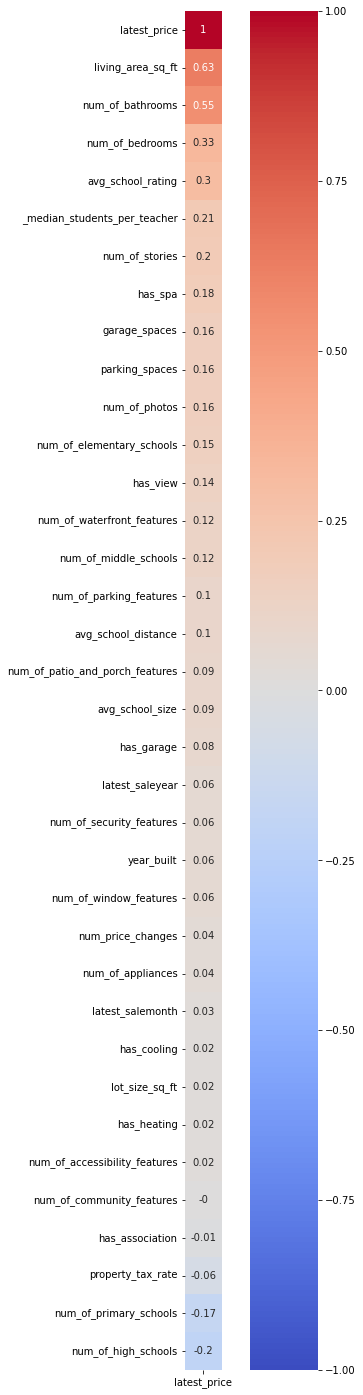

In [794]:
# Get feature price correlation
price_corr = (
    austin_df.drop(columns=remove_columns)
    .corr()[["latest_price"]]
    .sort_values(by="latest_price", ascending=False)
)

# Round correlation
corr = round(
    price_corr,
    2,
)

# Plot heatmap
plt.figure(figsize=(10, 25))
sns.heatmap(corr, square=True, cmap="coolwarm", annot=True, vmin=-1, vmax=1)


<AxesSubplot:title={'center':'Price Distribution'}, xlabel='latest_price', ylabel='Count'>

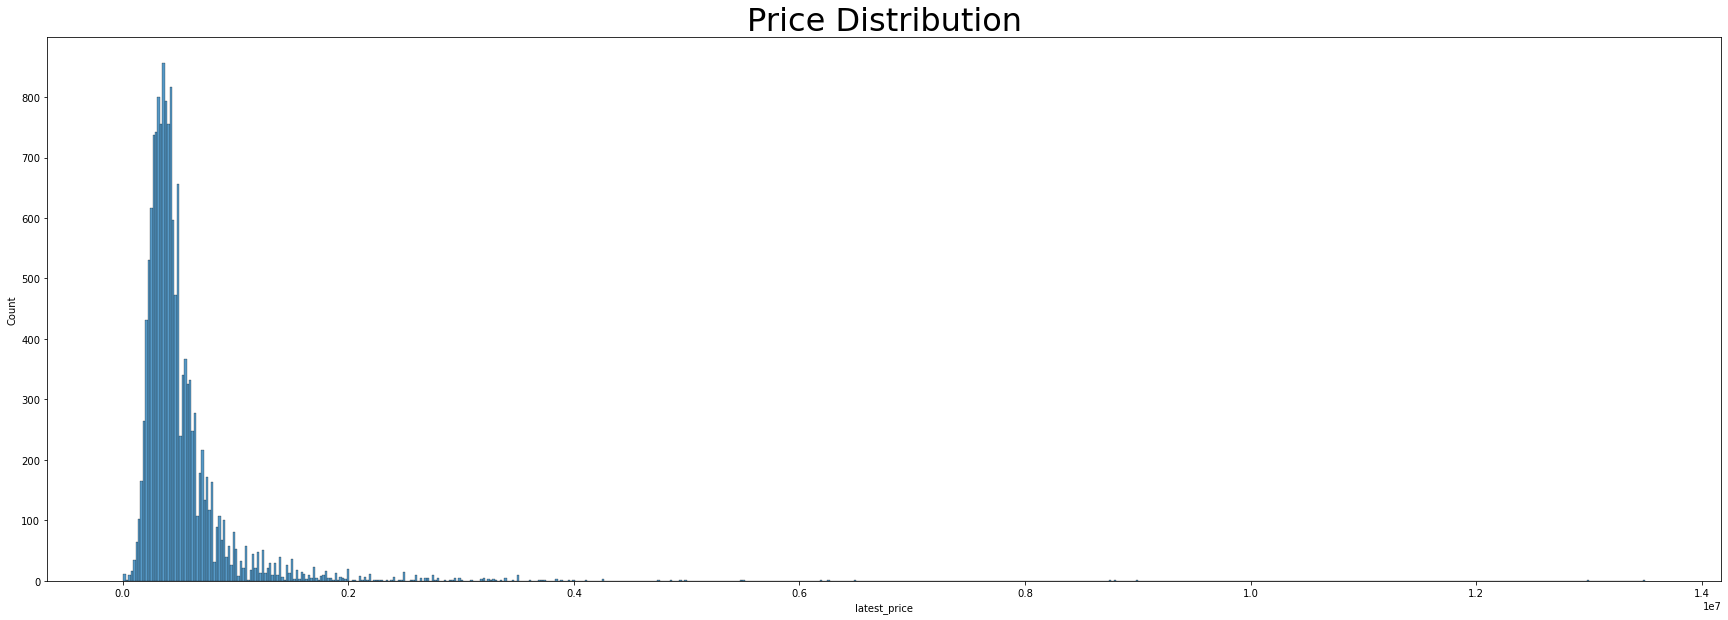

In [795]:
# Plot distribution of price
plt.figure(figsize=(30, 10))
plt.title("Price Distribution", fontsize=32)
sns.histplot(data=austin_df, x="latest_price")


> Distribution is heavily right skewed and need to remove outliers


<AxesSubplot:title={'center':'Price Outliers'}, xlabel='latest_price'>

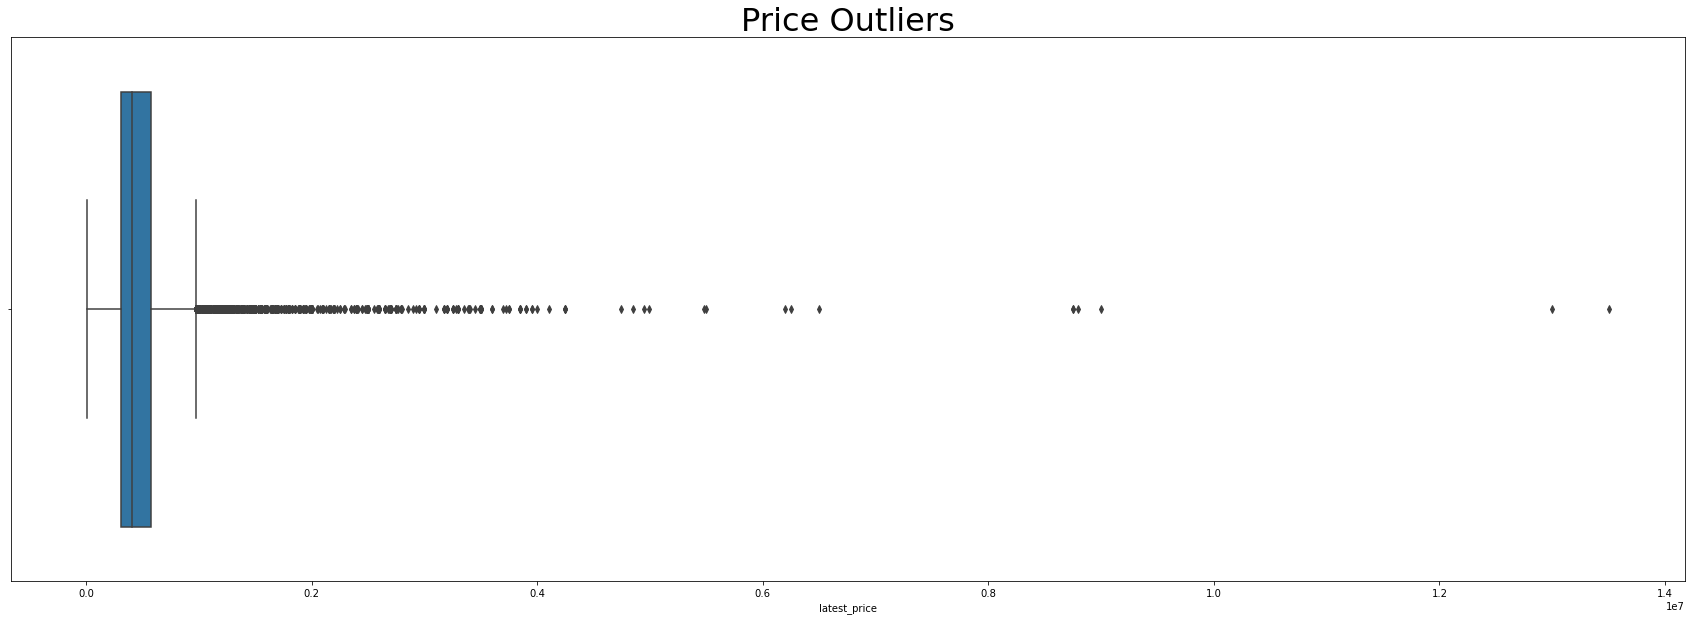

In [796]:
plt.figure(figsize=(30, 10))
plt.title("Price Outliers", fontsize=32)
sns.boxplot(x=austin_df["latest_price"])


In [797]:
mean_price = round(austin_df["latest_price"].mean(), 2)
median_price = round(austin_df["latest_price"].median(), 2)
quantile_88th = round(austin_df["latest_price"].quantile(0.88), 2)

print(
    f"Mean Price: ${mean_price}\nMedian Price: ${median_price}\n88th Percentile Price: ${quantile_88th}"
)


Mean Price: $511963.12
Median Price: $405000.0
88th Percentile Price: $774900.0


In [798]:
austin_df = austin_df[
    (austin_df["latest_price"] < quantile_88th) & (austin_df["latest_price"] > 180_000)
]

# Check shape after removing outliers
austin_df.shape


(12767, 47)

<AxesSubplot:title={'center':'Price After Removing Outliers'}, xlabel='latest_price'>

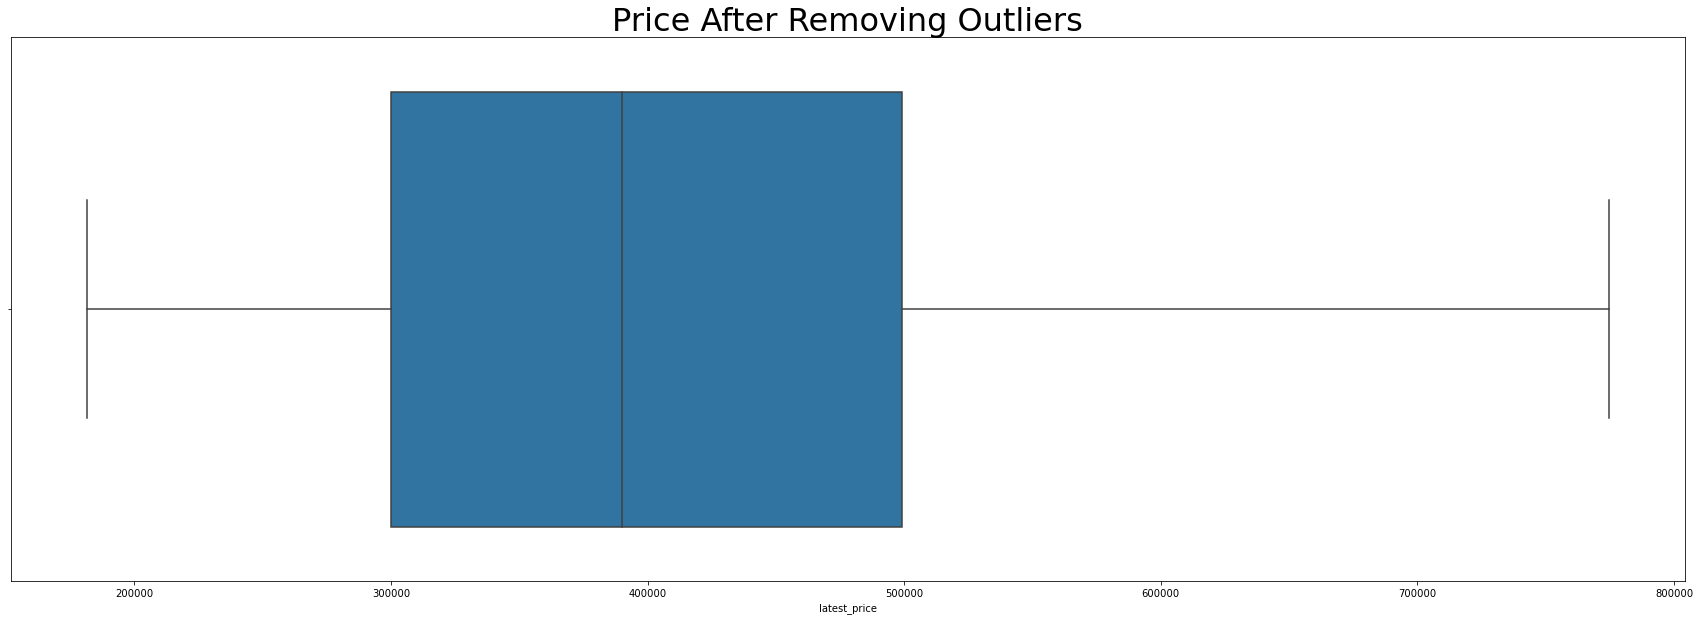

In [799]:
plt.figure(figsize=(30, 10))
plt.title("Price After Removing Outliers", fontsize=32)
sns.boxplot(x=austin_df["latest_price"])


<AxesSubplot:title={'center':'Price Distribution After Removing Outliers'}, xlabel='latest_price', ylabel='Count'>

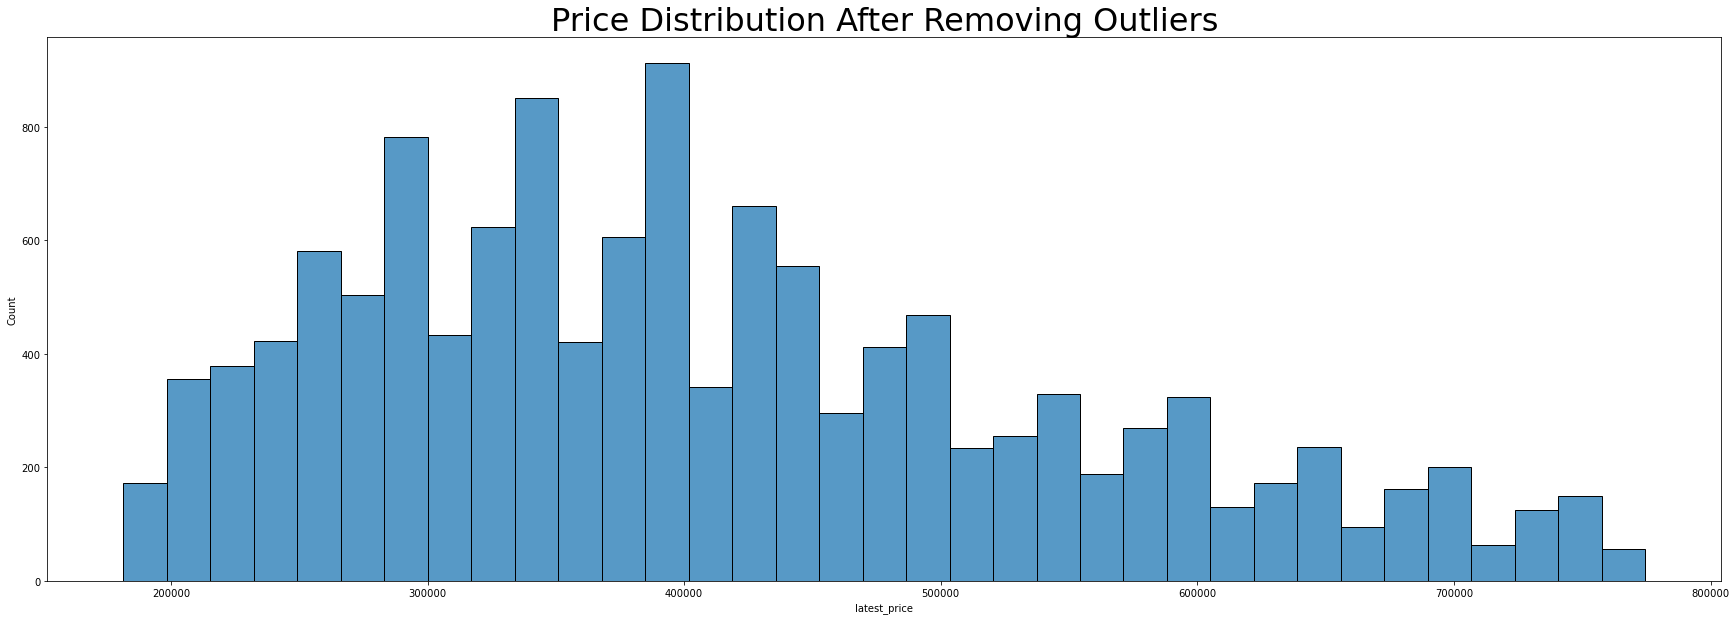

In [800]:
# Plot price distribution after removing outliers
plt.figure(figsize=(30, 10))
plt.title("Price Distribution After Removing Outliers", fontsize=32)
sns.histplot(x=austin_df["latest_price"])


> Removing outliers and below $100,000 house prices, distribution is more balanced


<AxesSubplot:>

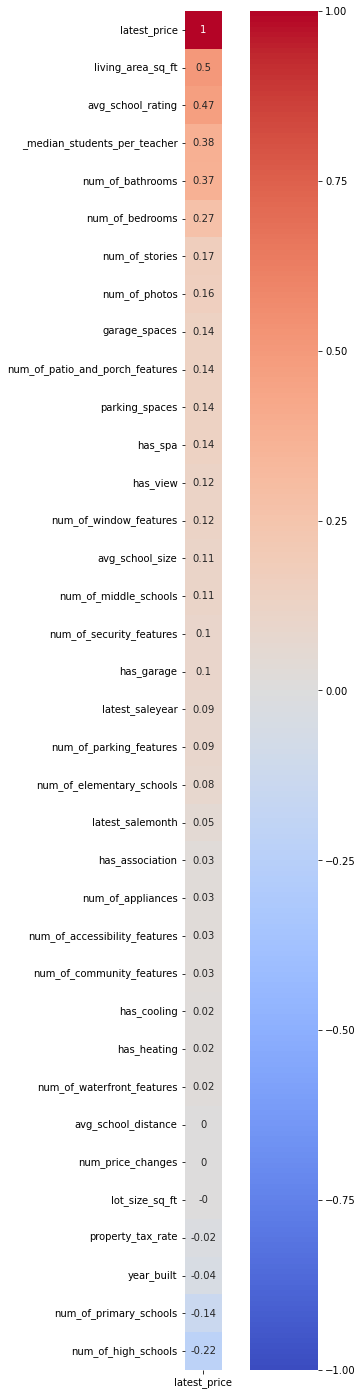

In [801]:
# Get feature price correlation after removing outliers
price_corr = (
    austin_df.drop(columns=remove_columns)
    .corr()[["latest_price"]]
    .sort_values(by="latest_price", ascending=False)
)

# Round correlation
corr = round(
    price_corr,
    2,
)

# Plot heatmap
plt.figure(figsize=(10, 25))
sns.heatmap(corr, square=True, cmap="coolwarm", annot=True, vmin=-1, vmax=1)


In [802]:
austin_df[["longitude", "latitude"]].min()


longitude   -98.022057
latitude     30.085030
dtype: float64

In [803]:
austin_df[["longitude", "latitude"]].max()


longitude   -97.570633
latitude     30.517323
dtype: float64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

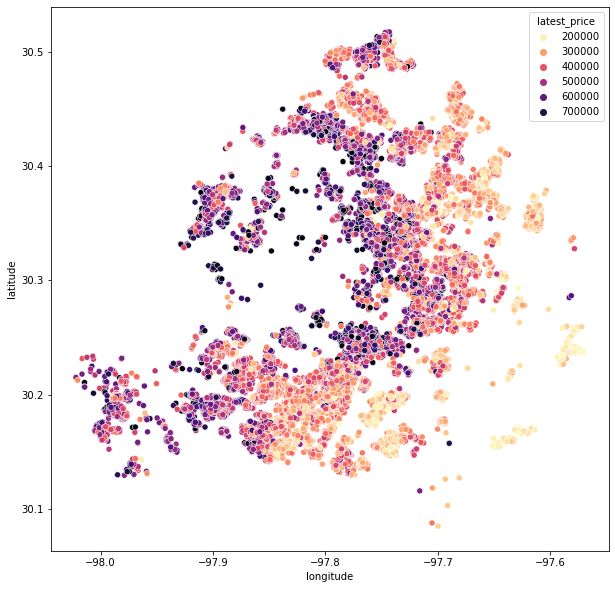

In [804]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=austin_df, x="longitude", y="latitude", hue="latest_price", palette="magma_r"
)


<AxesSubplot:title={'center':'Price Distribution By City'}, xlabel='city', ylabel='latest_price'>

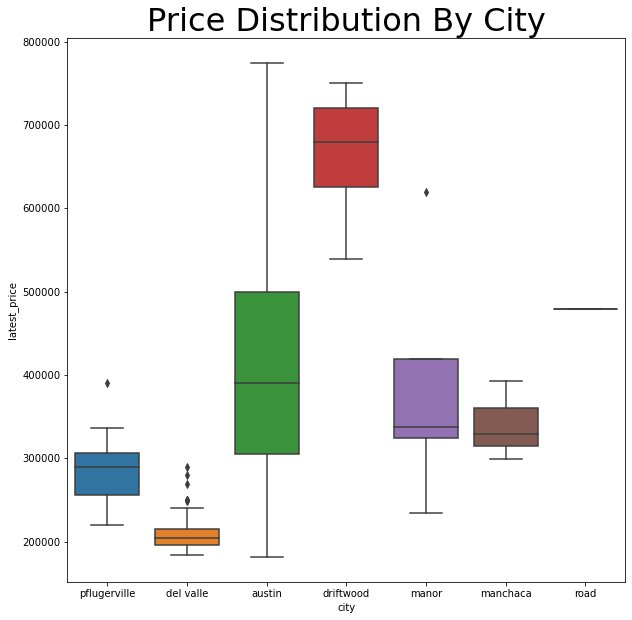

In [805]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By City", fontsize=32)
sns.boxplot(data=austin_df, x="city", y="latest_price")


In [806]:
austin_df = austin_df[austin_df["city"] != "road"]


<AxesSubplot:title={'center':'Price Distribution By Having HOA'}, xlabel='has_association', ylabel='latest_price'>

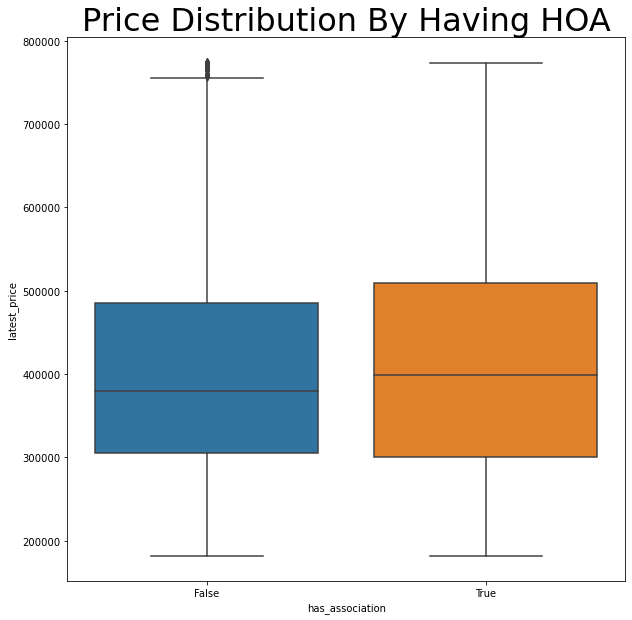

In [807]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having HOA", fontsize=32)
sns.boxplot(data=austin_df, x="has_association", y="latest_price")


> Having HOA slightly moves price median


<AxesSubplot:title={'center':'Price Distribution By Having Cooling System'}, xlabel='has_cooling', ylabel='latest_price'>

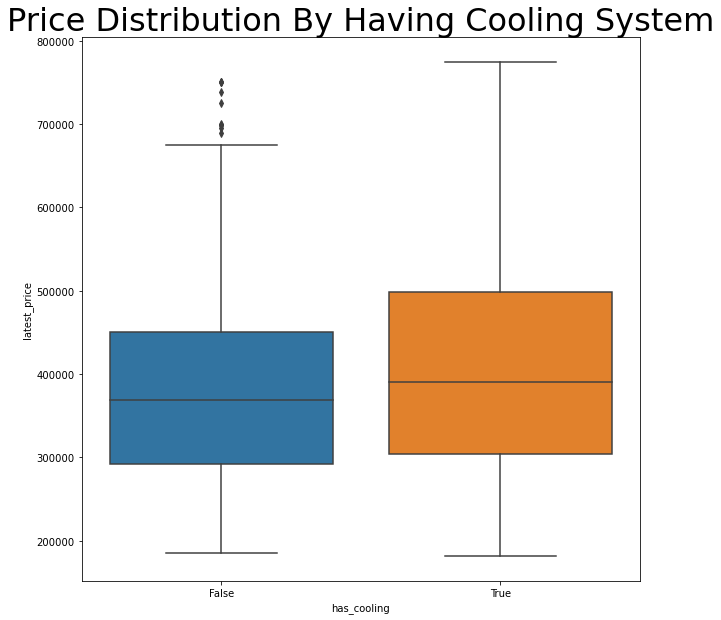

In [808]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having Cooling System", fontsize=32)
sns.boxplot(data=austin_df, x="has_cooling", y="latest_price")


> House with cooling increased overall price median


<AxesSubplot:title={'center':'Price Distribution By Having Heating'}, xlabel='has_heating', ylabel='latest_price'>

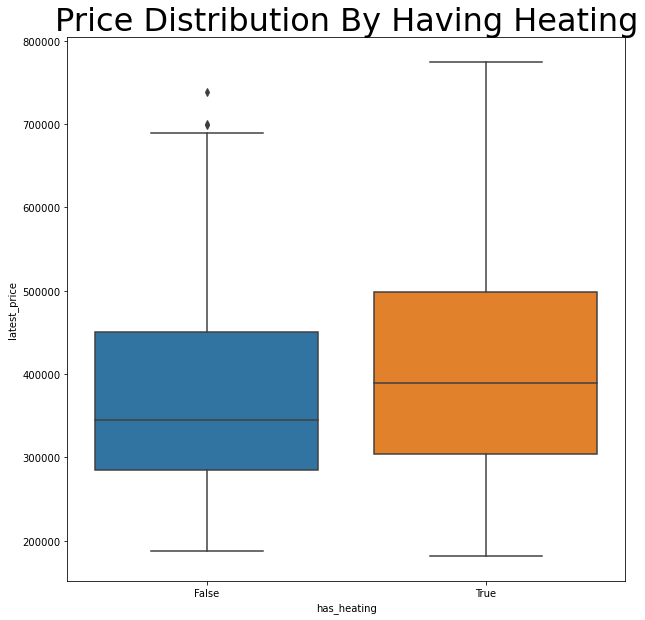

In [809]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having Heating", fontsize=32)
sns.boxplot(data=austin_df, x="has_heating", y="latest_price")


> House with heating increased house price median


<AxesSubplot:title={'center':'Price Distribution By Having Garage'}, xlabel='has_garage', ylabel='latest_price'>

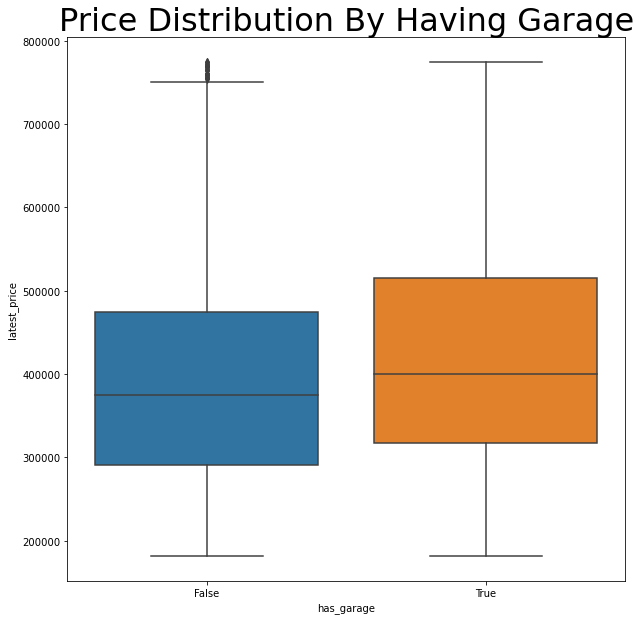

In [810]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having Garage", fontsize=32)
sns.boxplot(data=austin_df, x="has_garage", y="latest_price")


> Having a garage has slight increase on house price


<AxesSubplot:title={'center':'Price Distribution By Having SPA'}, xlabel='has_spa', ylabel='latest_price'>

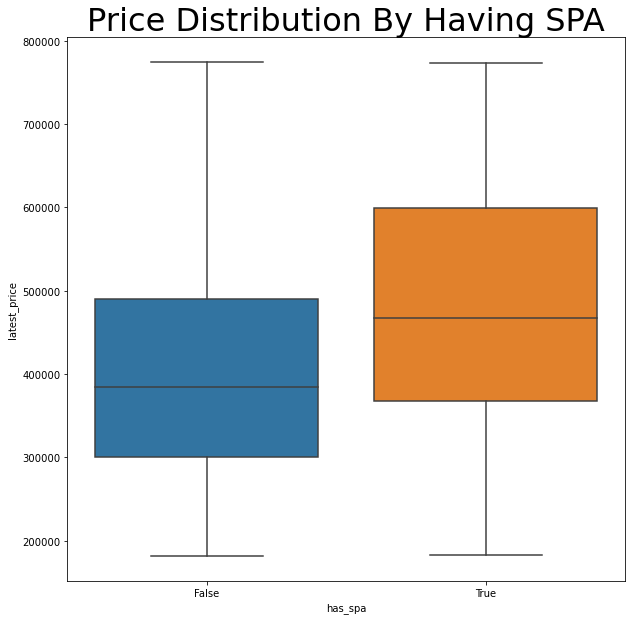

In [811]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having SPA", fontsize=32)
sns.boxplot(data=austin_df, x="has_spa", y="latest_price")


> House having a spa increased


<AxesSubplot:title={'center':'Price Distribution By Having View'}, xlabel='has_view', ylabel='latest_price'>

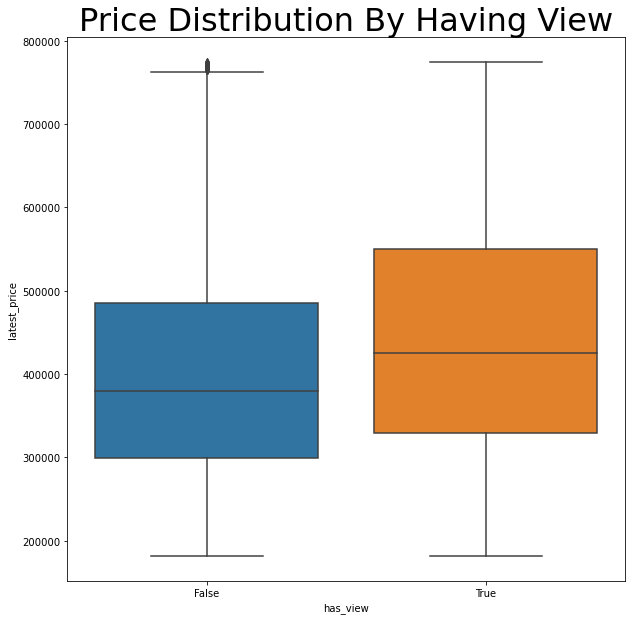

In [812]:
plt.figure(figsize=(10, 10))
plt.title("Price Distribution By Having View", fontsize=32)
sns.boxplot(data=austin_df, x="has_view", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Home Type'}, xlabel='home_type', ylabel='latest_price'>

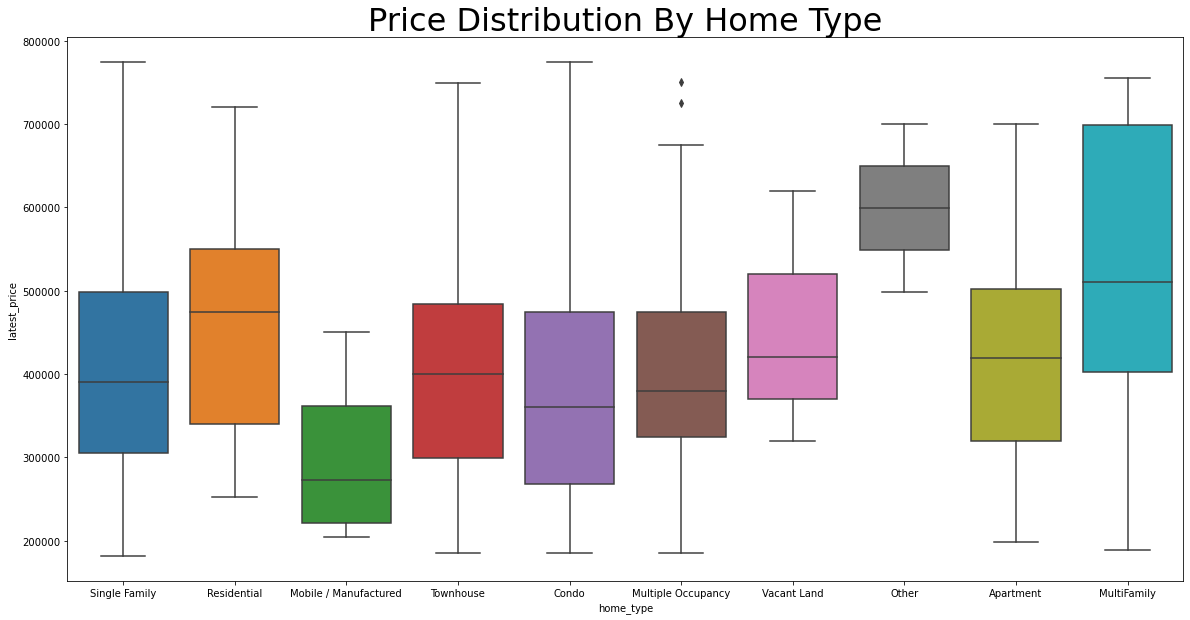

In [813]:
plt.figure(figsize=(20, 10))
plt.title("Price Distribution By Home Type", fontsize=32)
sns.boxplot(data=austin_df, x="home_type", y="latest_price")


> Home type has influence on house pricing


<AxesSubplot:title={'center':'Price Distribution By Parking Spaces'}, xlabel='parking_spaces', ylabel='latest_price'>

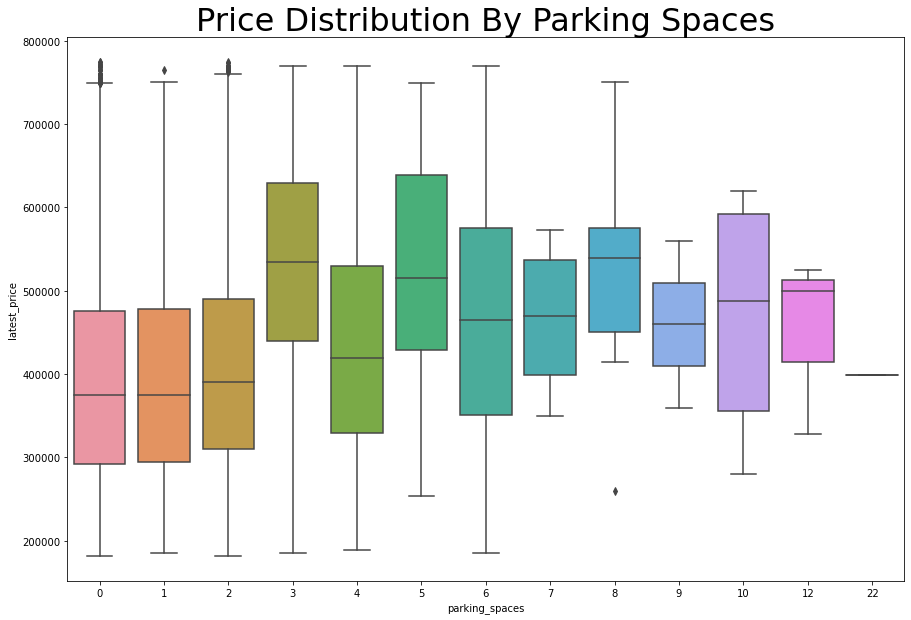

In [814]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Parking Spaces", fontsize=32)
sns.boxplot(data=austin_df, x="parking_spaces", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Price Changes'}, xlabel='num_price_changes', ylabel='latest_price'>

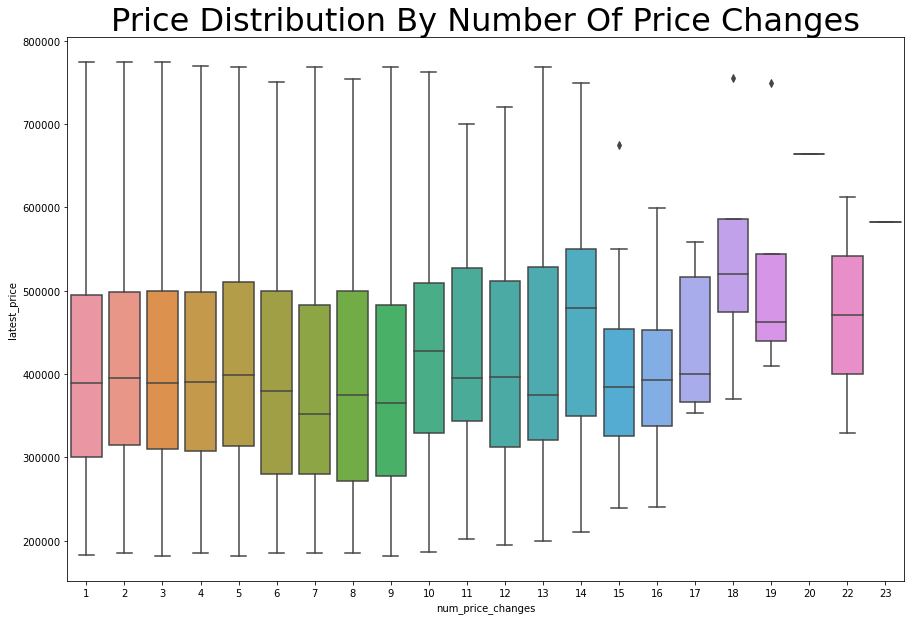

In [815]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Price Changes", fontsize=32)
sns.boxplot(data=austin_df, x="num_price_changes", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Sale Month'}, xlabel='latest_salemonth', ylabel='latest_price'>

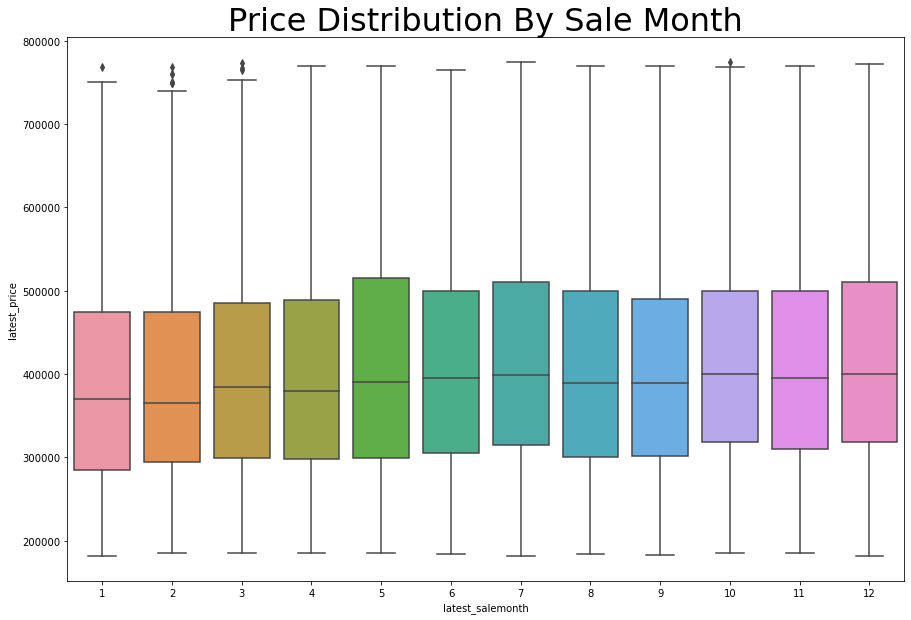

In [816]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Sale Month", fontsize=32)
sns.boxplot(data=austin_df, x="latest_salemonth", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Sale Year'}, xlabel='latest_saleyear', ylabel='latest_price'>

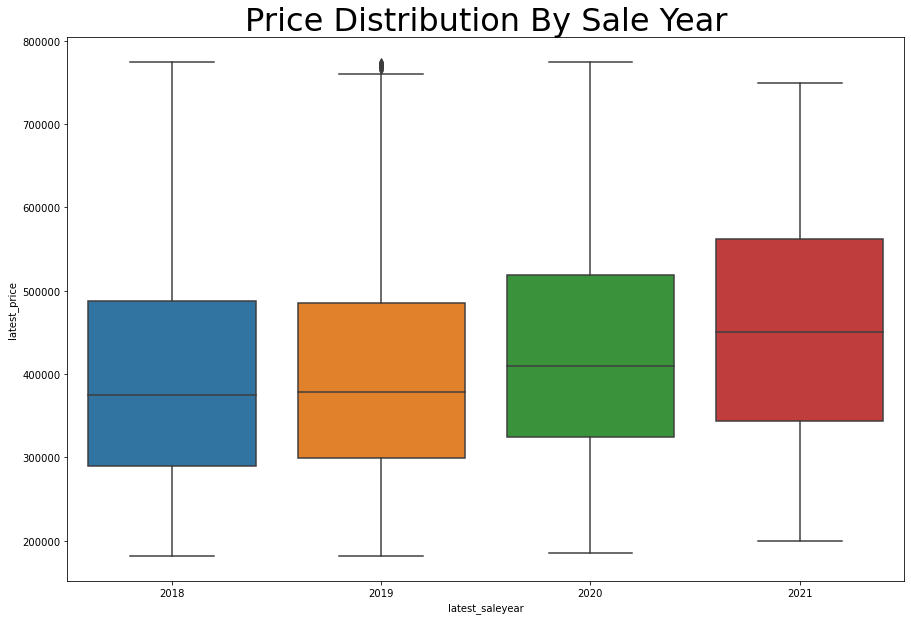

In [817]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Sale Year", fontsize=32)
sns.boxplot(data=austin_df, x="latest_saleyear", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Accessibility Features'}, xlabel='num_of_accessibility_features', ylabel='latest_price'>

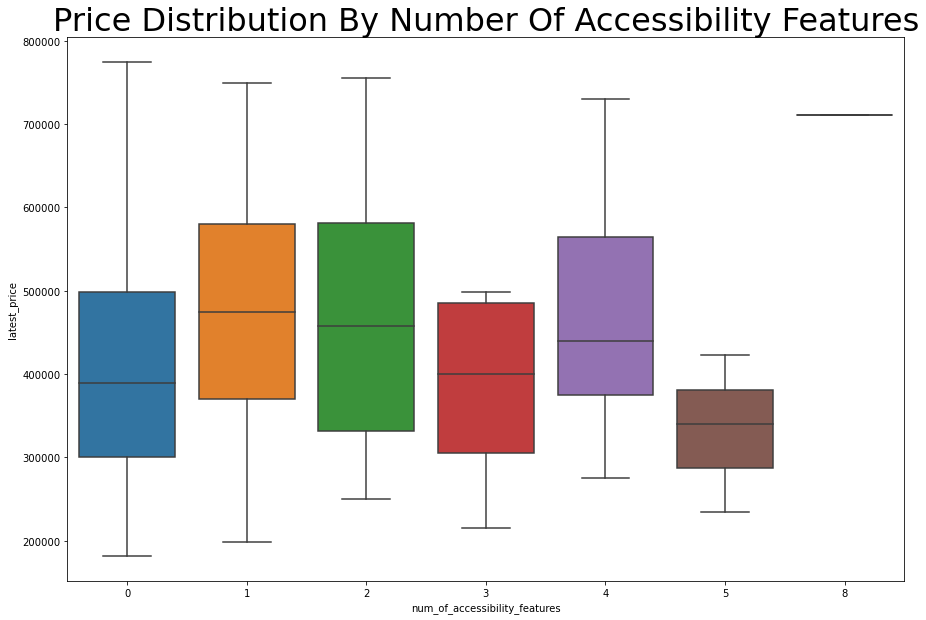

In [818]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Accessibility Features", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_accessibility_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Appliances'}, xlabel='num_of_appliances', ylabel='latest_price'>

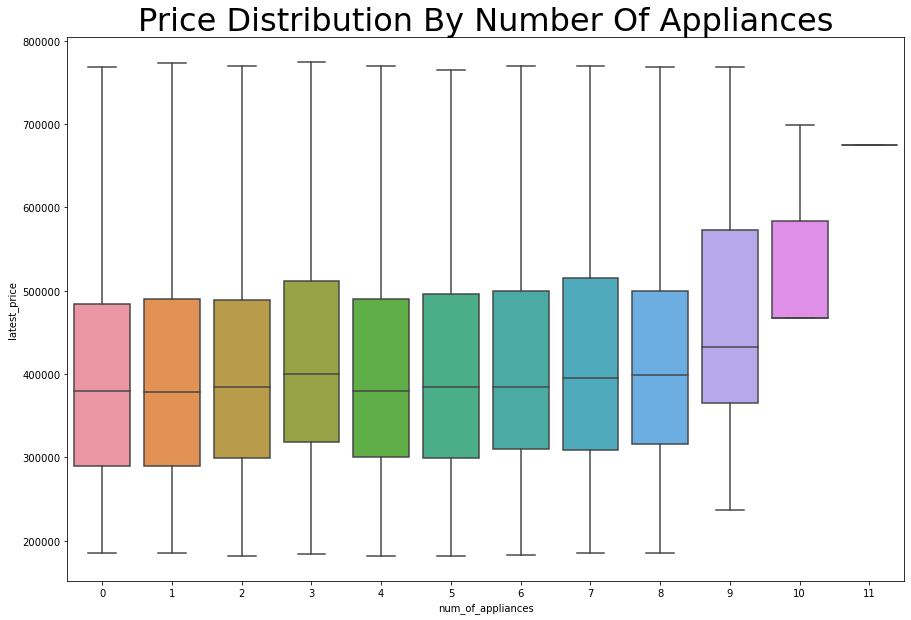

In [819]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Appliances", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_appliances", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Parking Features'}, xlabel='num_of_parking_features', ylabel='latest_price'>

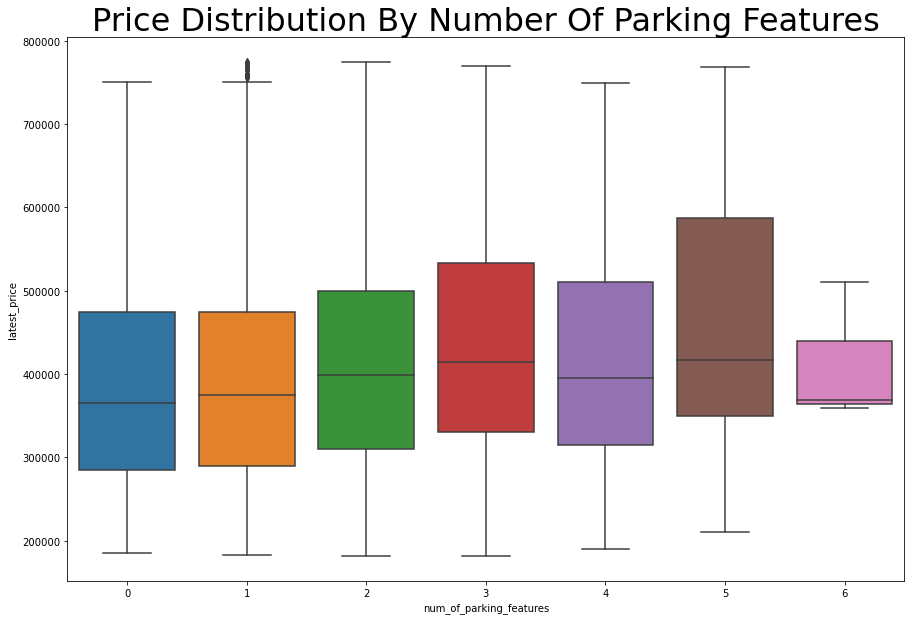

In [820]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Parking Features", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_parking_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Patio and Porch'}, xlabel='num_of_patio_and_porch_features', ylabel='latest_price'>

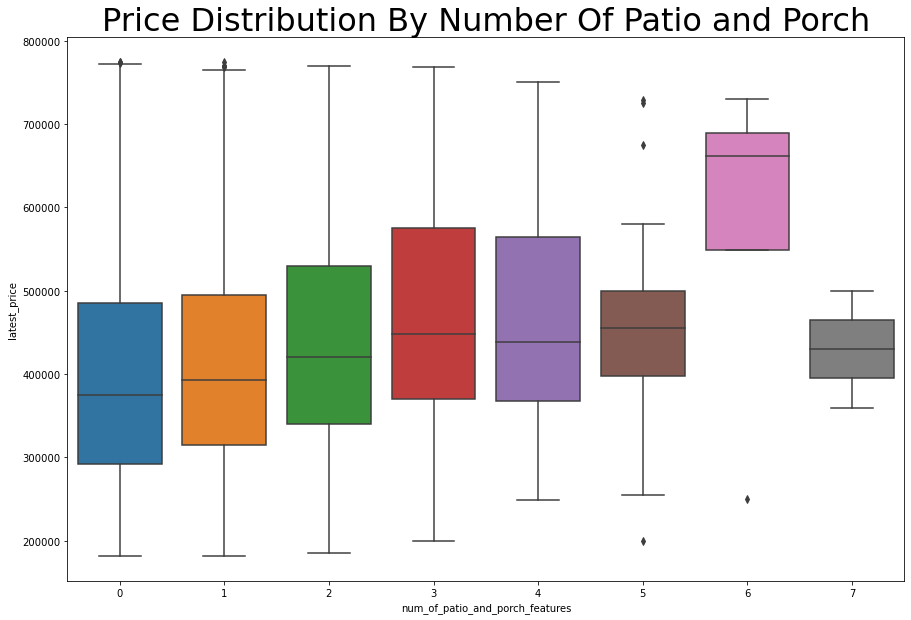

In [821]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Patio and Porch", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_patio_and_porch_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Security'}, xlabel='num_of_security_features', ylabel='latest_price'>

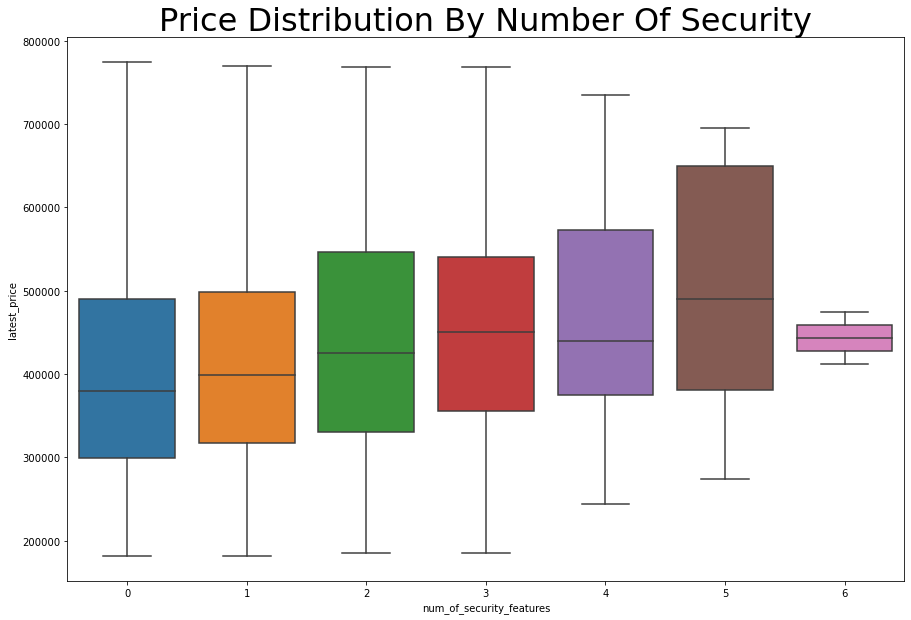

In [822]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Security", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_security_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Waterfront'}, xlabel='num_of_waterfront_features', ylabel='latest_price'>

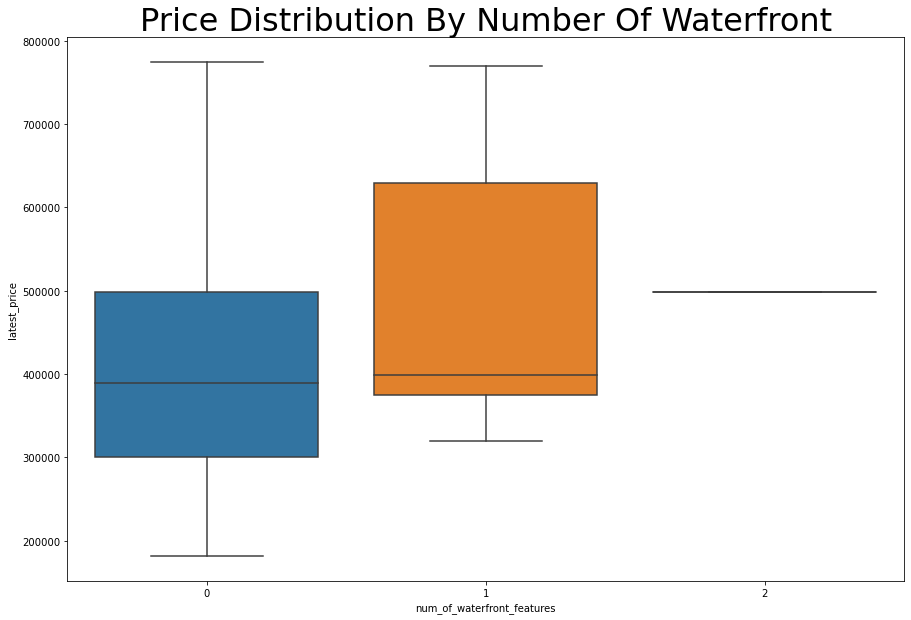

In [823]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Waterfront", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_waterfront_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Window'}, xlabel='num_of_window_features', ylabel='latest_price'>

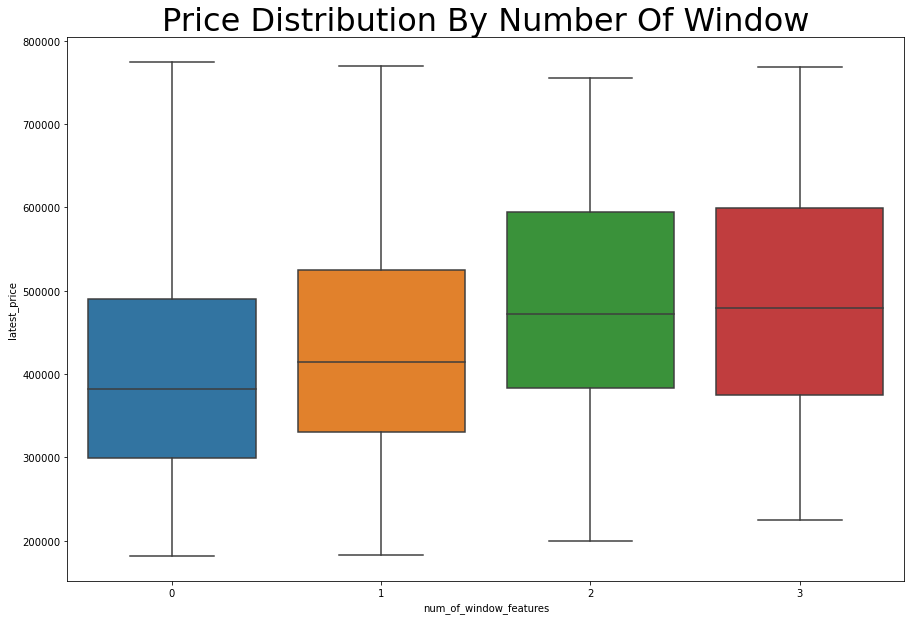

In [824]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Window", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_window_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Community Features'}, xlabel='num_of_community_features', ylabel='latest_price'>

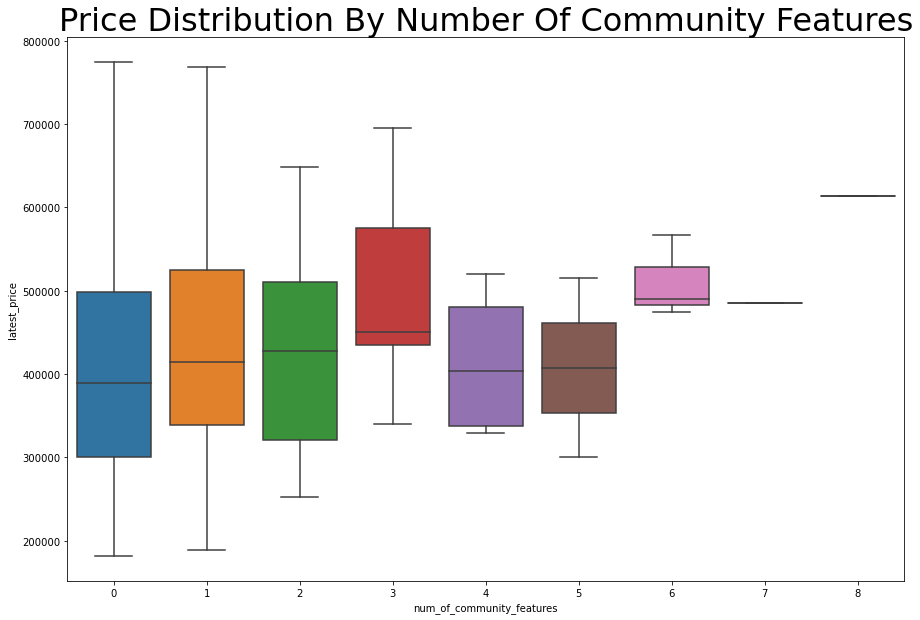

In [825]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Community Features", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_community_features", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Primary Schools'}, xlabel='num_of_primary_schools', ylabel='latest_price'>

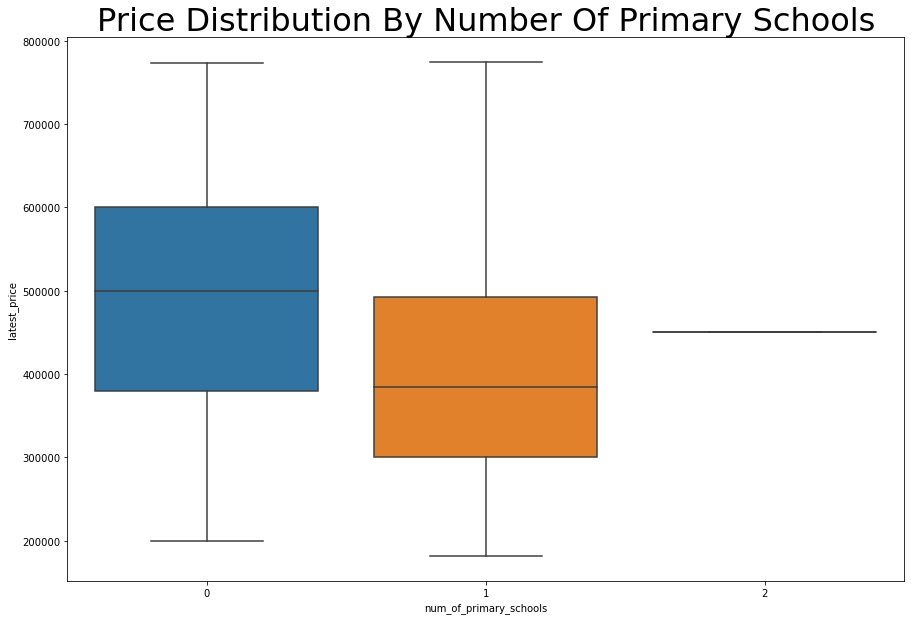

In [826]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Primary Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_primary_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Elementary Schools'}, xlabel='num_of_elementary_schools', ylabel='latest_price'>

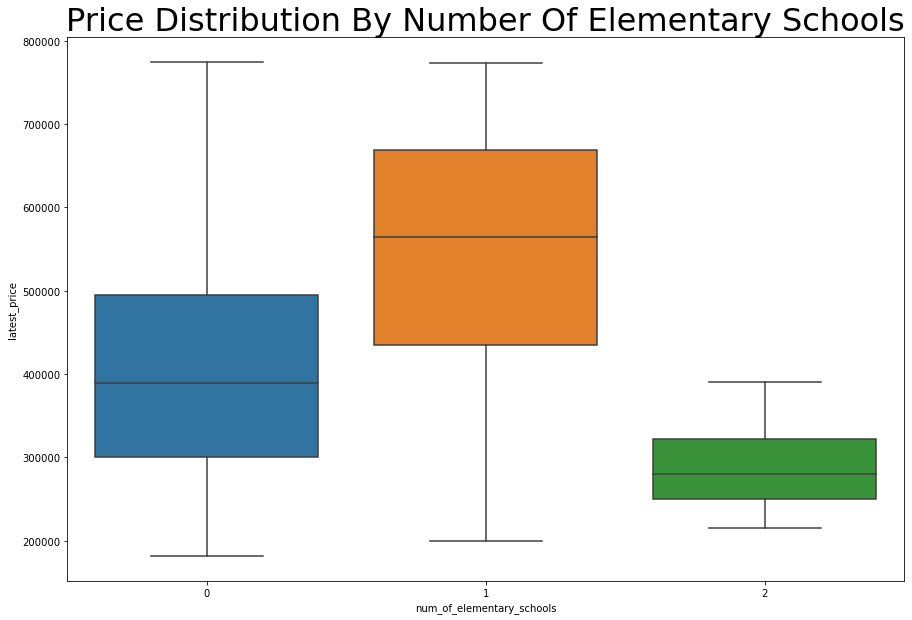

In [827]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Elementary Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_elementary_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Middle Schools'}, xlabel='num_of_middle_schools', ylabel='latest_price'>

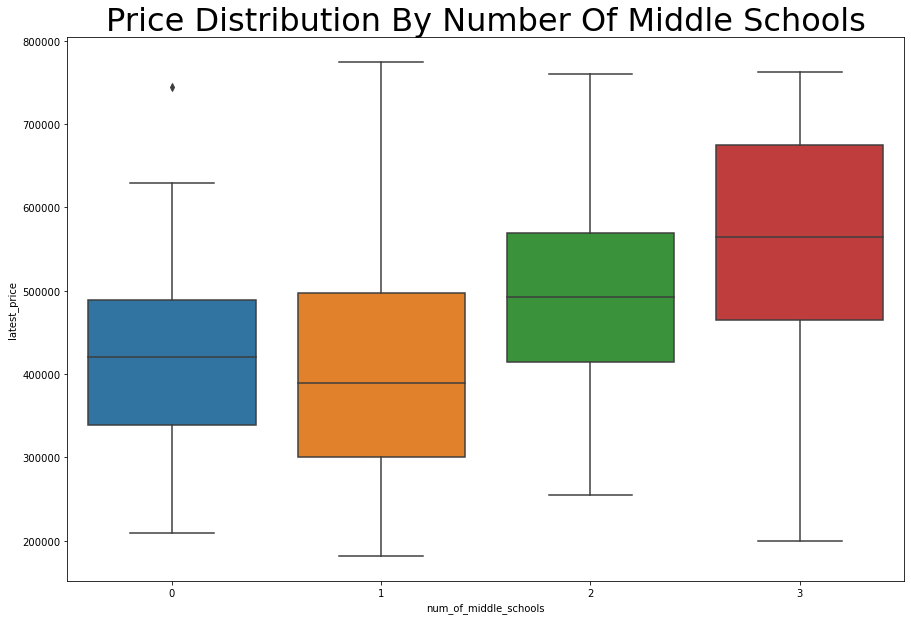

In [828]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Middle Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_middle_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of High Schools'}, xlabel='num_of_high_schools', ylabel='latest_price'>

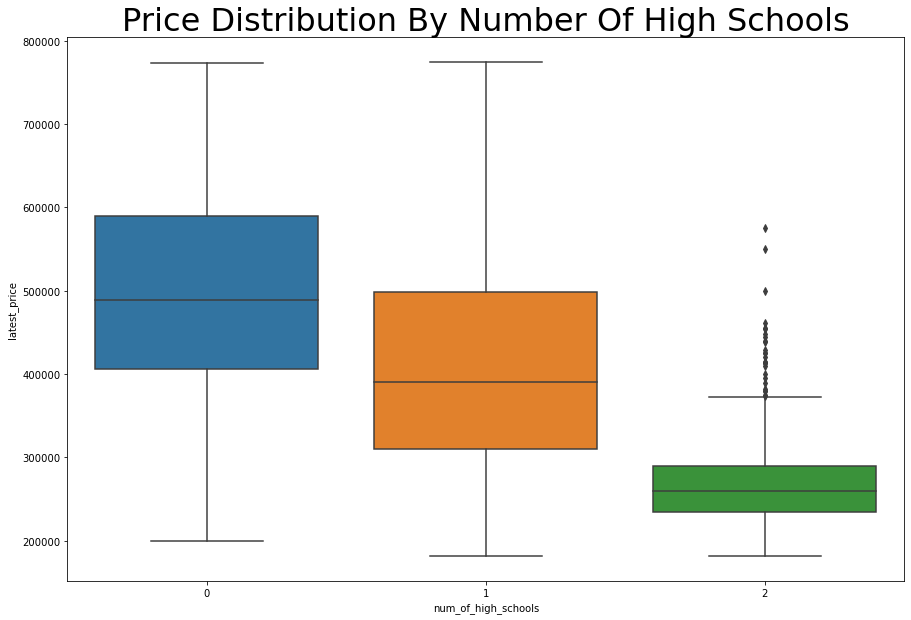

In [829]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of High Schools", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_high_schools", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Median Students Per Teacher'}, xlabel='_median_students_per_teacher', ylabel='latest_price'>

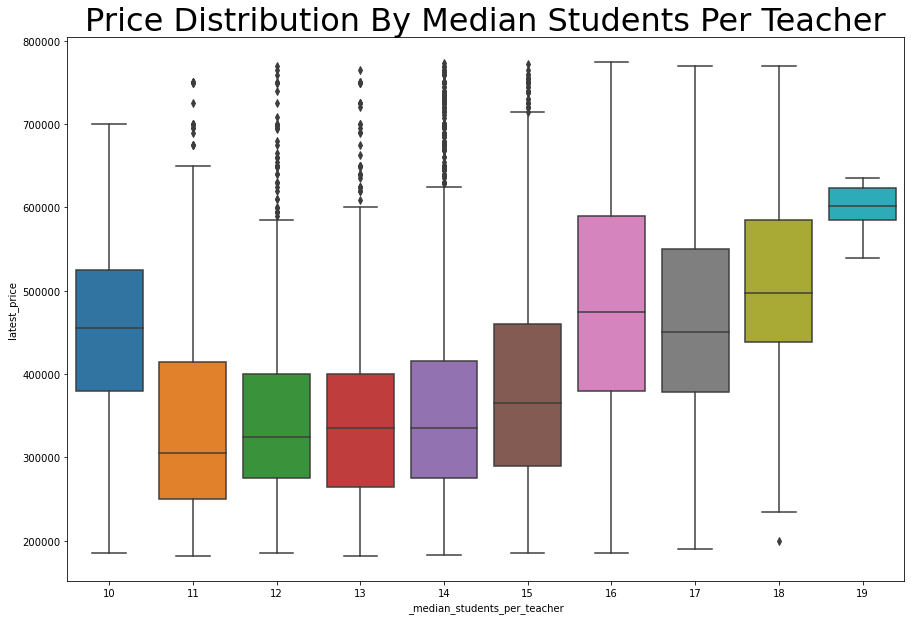

In [830]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Median Students Per Teacher", fontsize=32)
sns.boxplot(data=austin_df, x="_median_students_per_teacher", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Bathrooms'}, xlabel='num_of_bathrooms', ylabel='latest_price'>

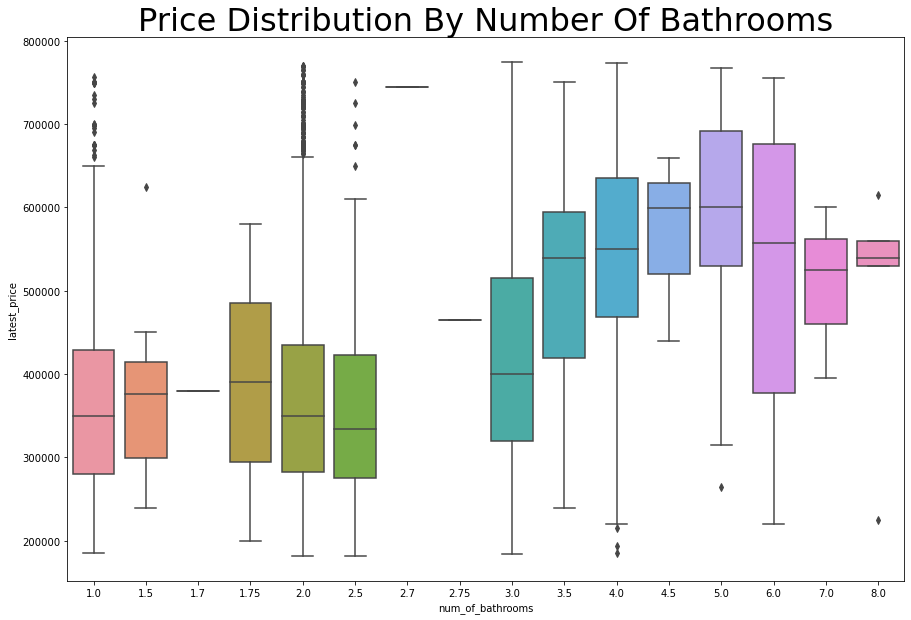

In [831]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Bathrooms", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_bathrooms", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Bedrooms'}, xlabel='num_of_bedrooms', ylabel='latest_price'>

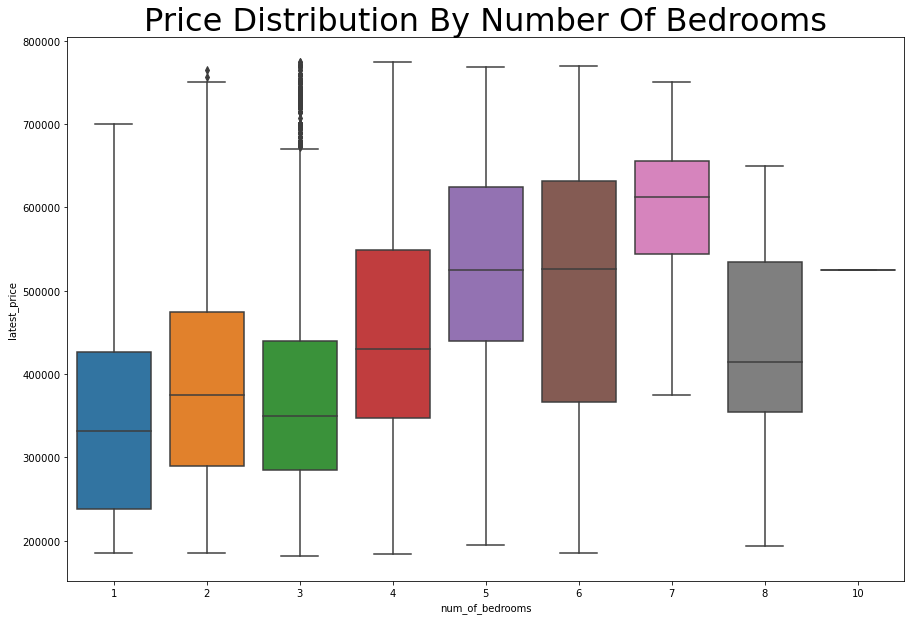

In [832]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Bedrooms", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_bedrooms", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Number Of Stories'}, xlabel='num_of_stories', ylabel='latest_price'>

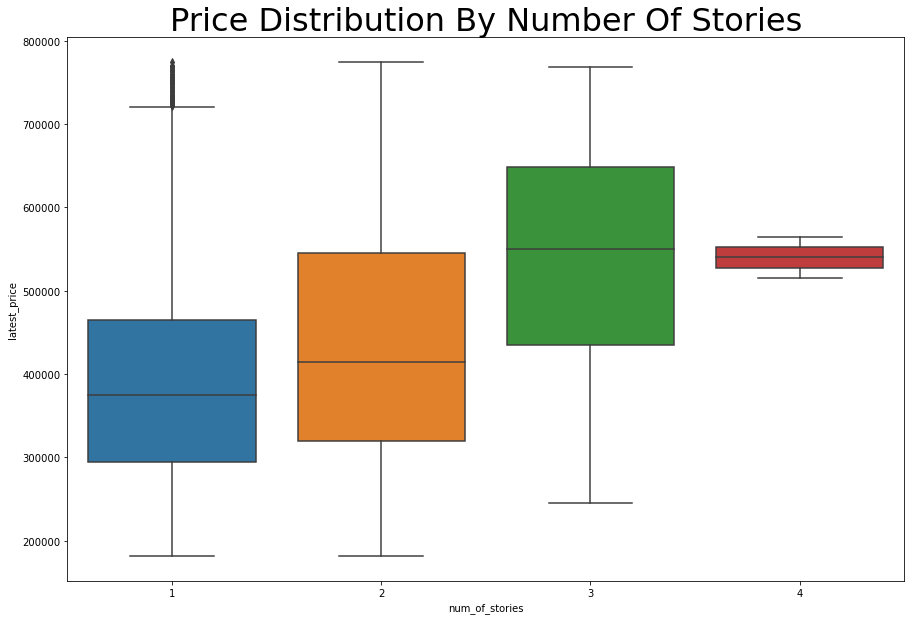

In [833]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Number Of Stories", fontsize=32)
sns.boxplot(data=austin_df, x="num_of_stories", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Property Tax Rate'}, xlabel='property_tax_rate', ylabel='latest_price'>

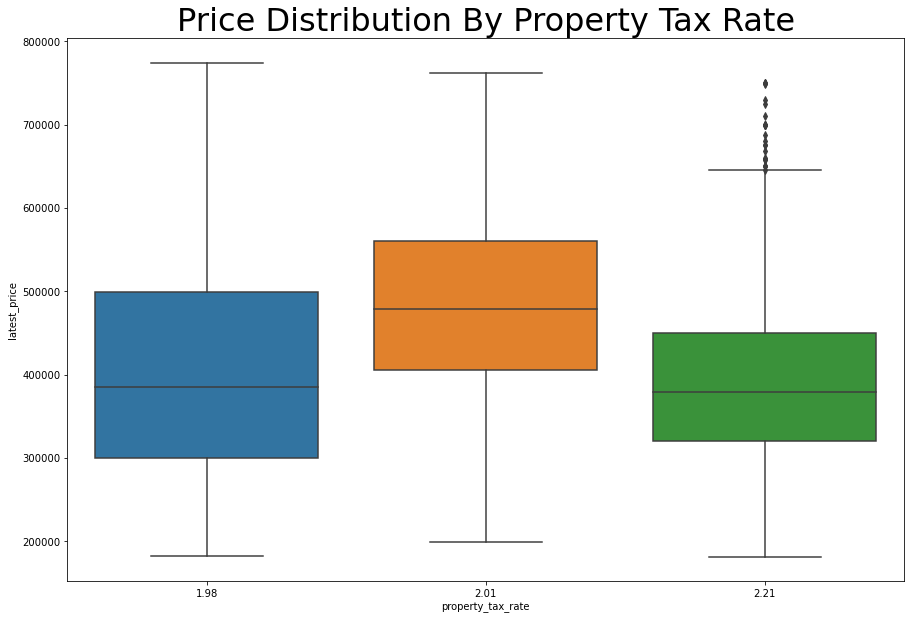

In [834]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Property Tax Rate", fontsize=32)
sns.boxplot(data=austin_df, x="property_tax_rate", y="latest_price")


<AxesSubplot:title={'center':'Price Distribution By Garage Spaces'}, xlabel='garage_spaces', ylabel='latest_price'>

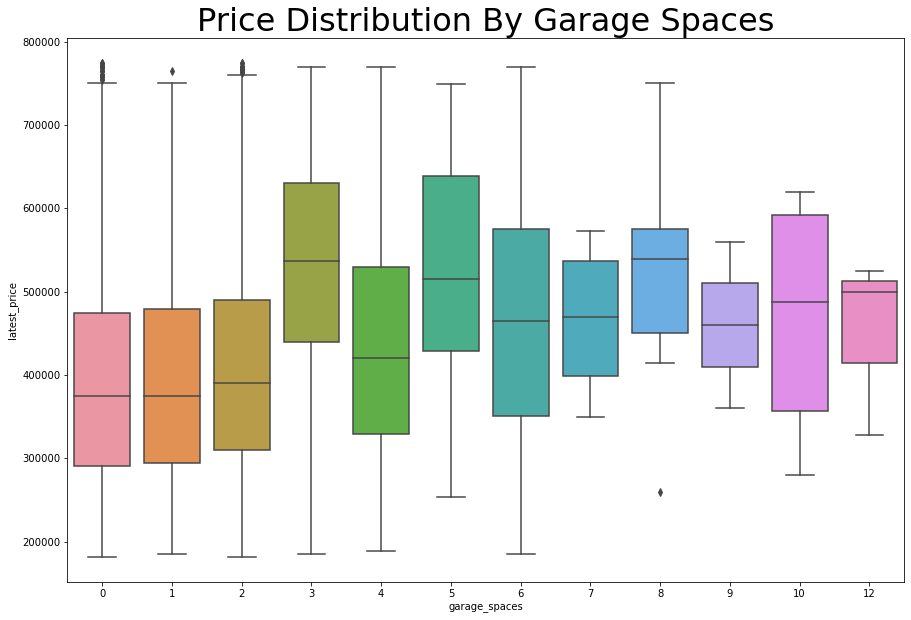

In [835]:
plt.figure(figsize=(15, 10))
plt.title("Price Distribution By Garage Spaces", fontsize=32)
sns.boxplot(data=austin_df, x="garage_spaces", y="latest_price")


<AxesSubplot:title={'center':'Price By Year Built'}, xlabel='year_built', ylabel='latest_price'>

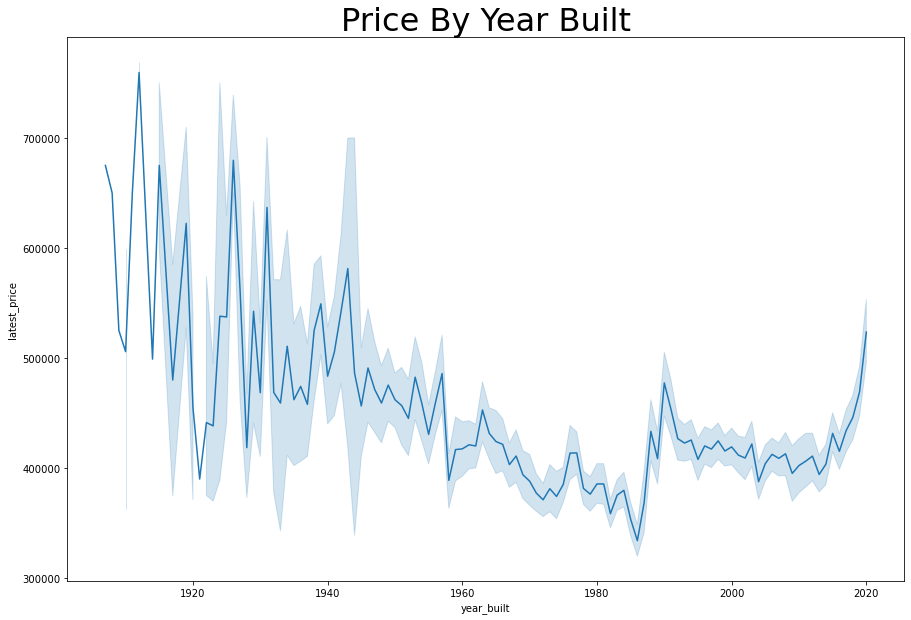

In [836]:
plt.figure(figsize=(15, 10))
plt.title("Price By Year Built", fontsize=32)
sns.lineplot(data=austin_df, x="year_built", y="latest_price")


In [837]:
austin_df["age"] = datetime.date.today().year - austin_df["year_built"]


<AxesSubplot:title={'center':'Price By Age'}, xlabel='age', ylabel='latest_price'>

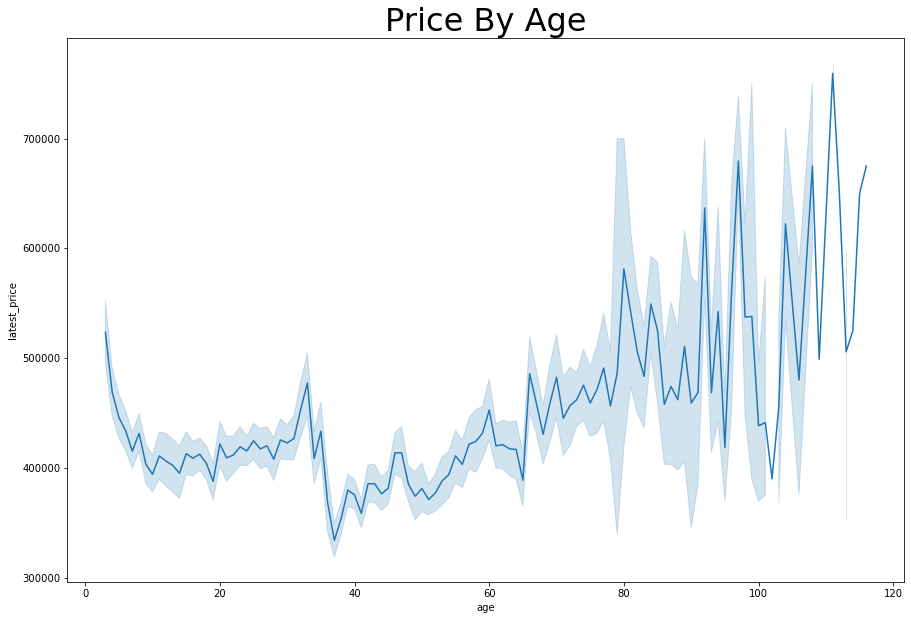

In [838]:
austin_df
plt.figure(figsize=(15, 10))
plt.title("Price By Age", fontsize=32)
sns.lineplot(data=austin_df, x="age", y="latest_price")


<AxesSubplot:title={'center':'Price By Number Of Photos'}, xlabel='num_of_photos', ylabel='latest_price'>

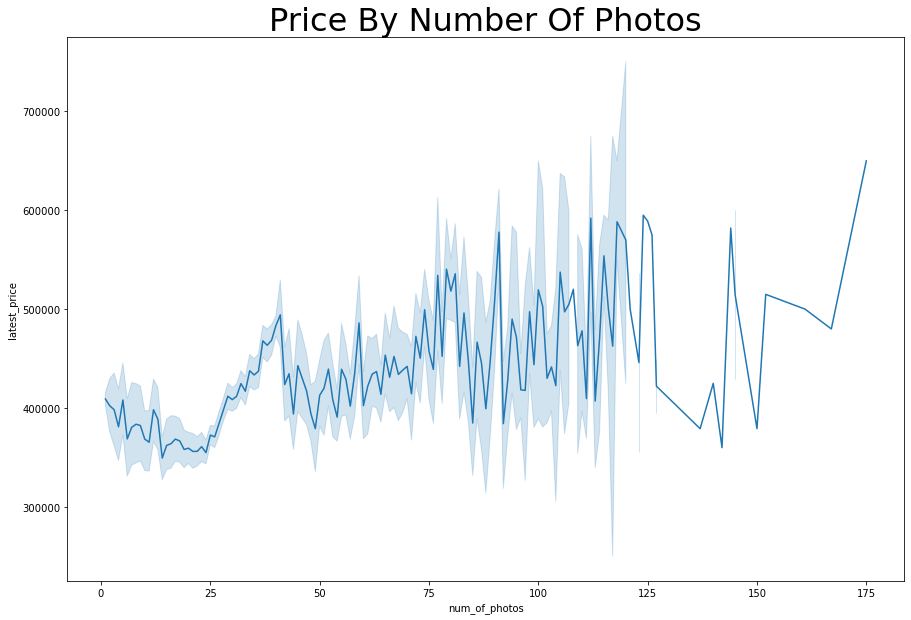

In [839]:
plt.figure(figsize=(15, 10))
plt.title("Price By Number Of Photos", fontsize=32)
sns.lineplot(data=austin_df, x="num_of_photos", y="latest_price")


<AxesSubplot:title={'center':'Price By Lot Size Sq Ft'}, xlabel='lot_size_sq_ft', ylabel='latest_price'>

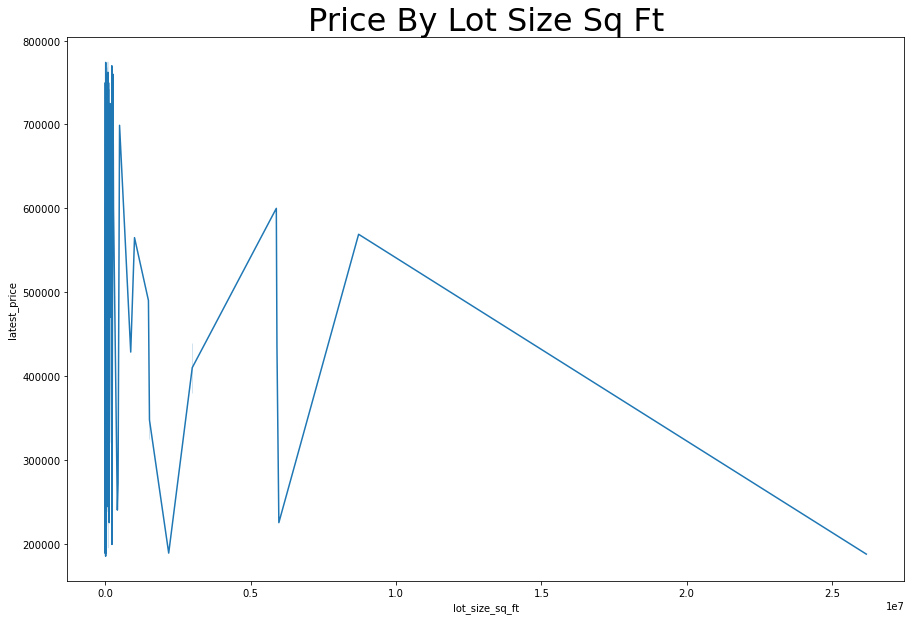

In [840]:
plt.figure(figsize=(15, 10))
plt.title("Price By Lot Size Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="lot_size_sq_ft", y="latest_price")


In [841]:
austin_df = austin_df[austin_df["lot_size_sq_ft"] < 15_000]


<AxesSubplot:title={'center':'Price By Lot Size Sq Ft'}, xlabel='lot_size_sq_ft', ylabel='latest_price'>

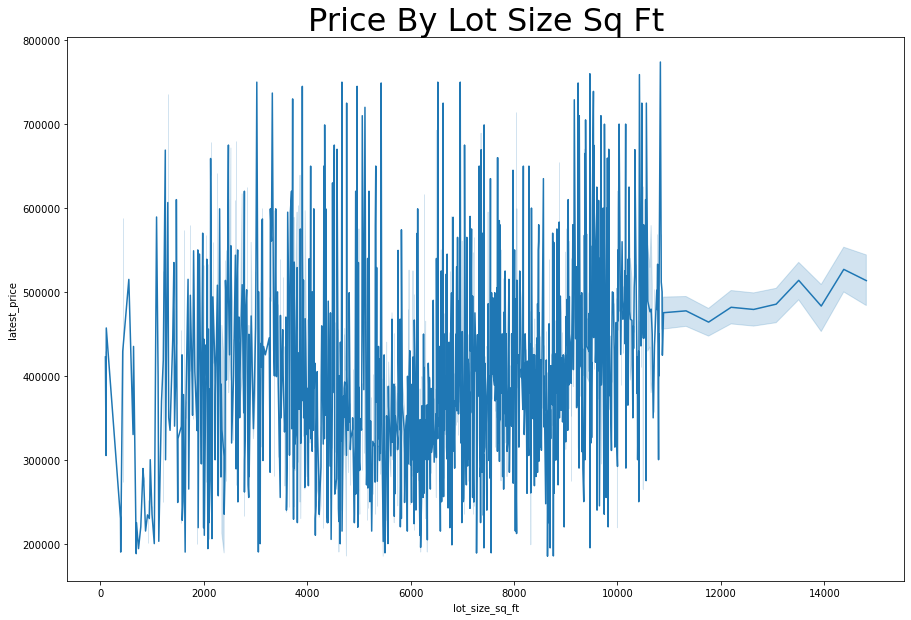

In [842]:
plt.figure(figsize=(15, 10))
plt.title("Price By Lot Size Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="lot_size_sq_ft", y="latest_price")


<AxesSubplot:title={'center':'Price By Lot Size Sq Ft'}, xlabel='lot_size_sq_ft', ylabel='latest_price'>

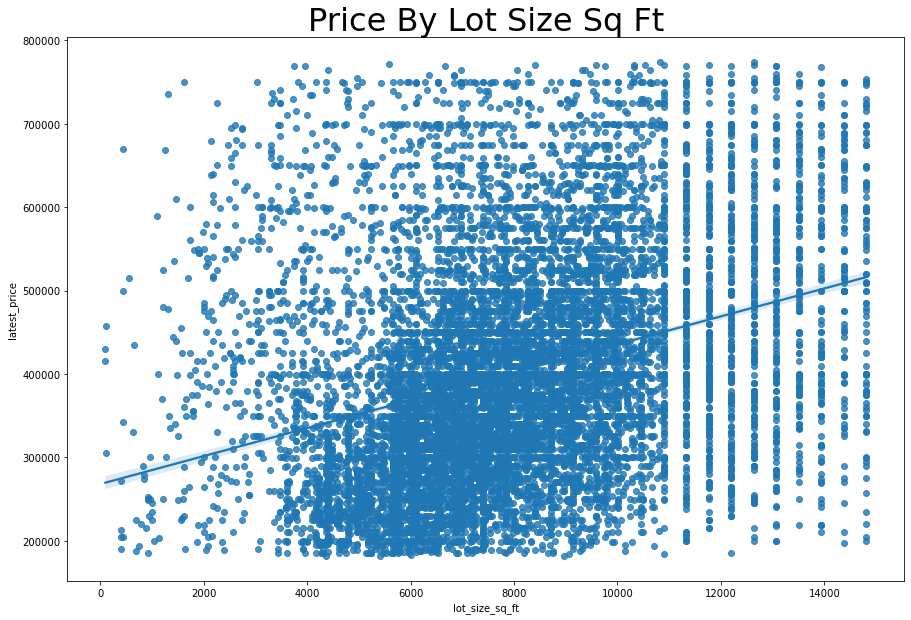

In [843]:
plt.figure(figsize=(15, 10))
plt.title("Price By Lot Size Sq Ft", fontsize=32)
sns.regplot(x=austin_df["lot_size_sq_ft"], y=austin_df["latest_price"])


<AxesSubplot:title={'center':'Price By Living Area Sq Ft'}, xlabel='living_area_sq_ft', ylabel='latest_price'>

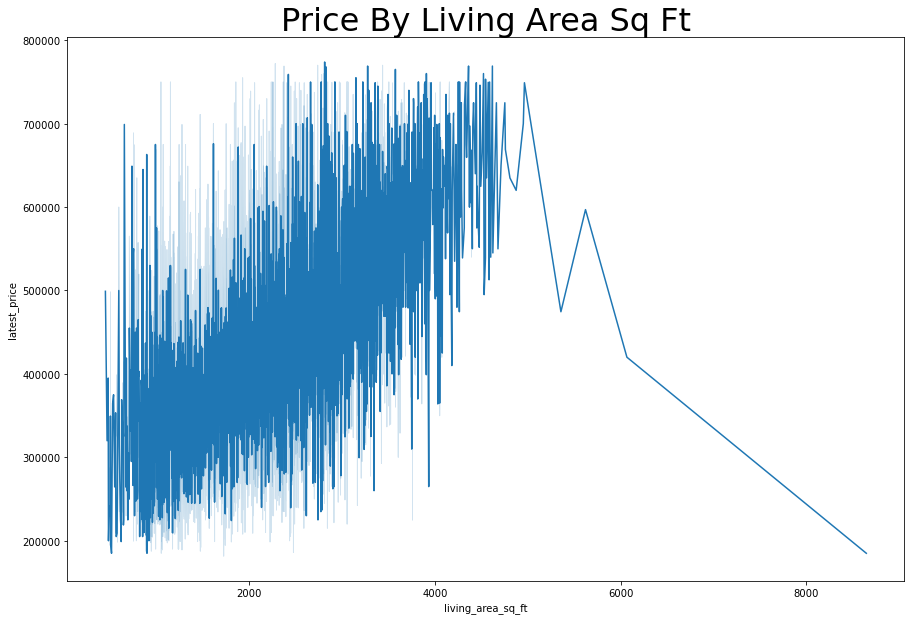

In [844]:
plt.figure(figsize=(15, 10))
plt.title("Price By Living Area Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="living_area_sq_ft", y="latest_price")


In [845]:
living_area_99th = austin_df["living_area_sq_ft"].quantile(0.99)
austin_df = austin_df[austin_df["living_area_sq_ft"] < living_area_99th]


<AxesSubplot:title={'center':'Price By Living Area Sq Ft'}, xlabel='living_area_sq_ft', ylabel='latest_price'>

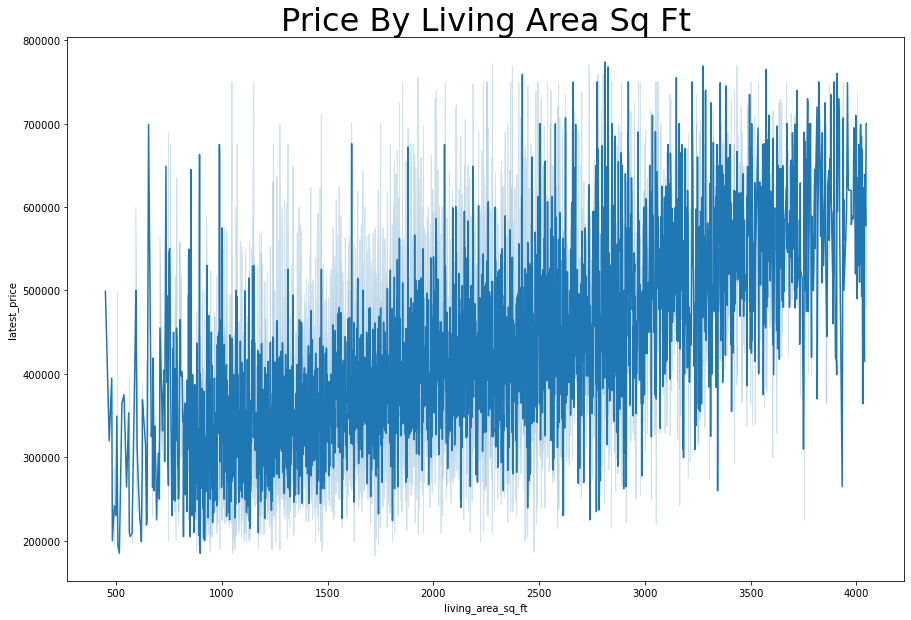

In [846]:
plt.figure(figsize=(15, 10))
plt.title("Price By Living Area Sq Ft", fontsize=32)
sns.lineplot(data=austin_df, x="living_area_sq_ft", y="latest_price")


<AxesSubplot:title={'center':'Price By Avg School Distance'}, xlabel='avg_school_distance', ylabel='latest_price'>

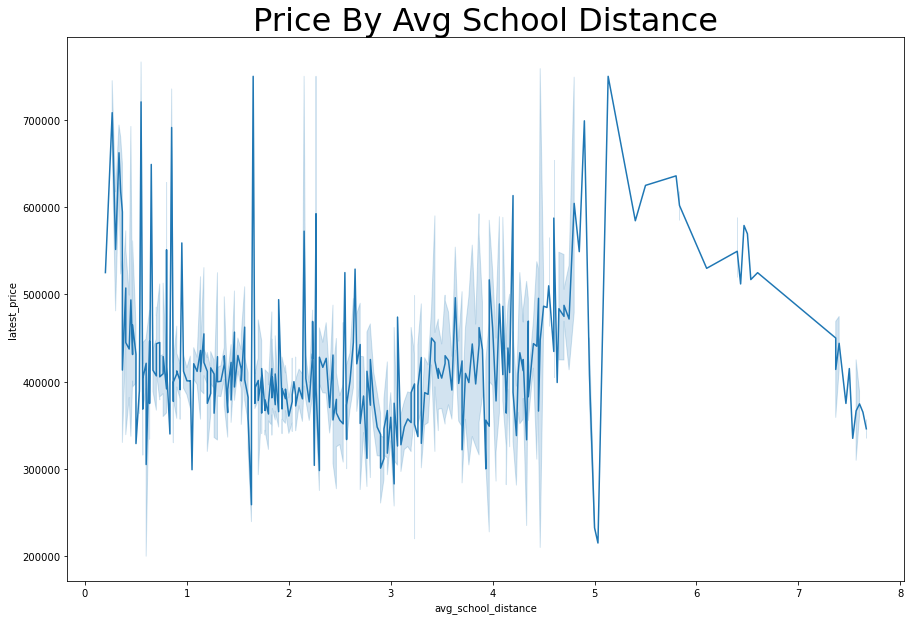

In [847]:
plt.figure(figsize=(15, 10))
plt.title("Price By Avg School Distance", fontsize=32)
sns.lineplot(data=austin_df, x="avg_school_distance", y="latest_price")


<AxesSubplot:title={'center':'Price By Avg School Distance'}, xlabel='avg_school_rating', ylabel='latest_price'>

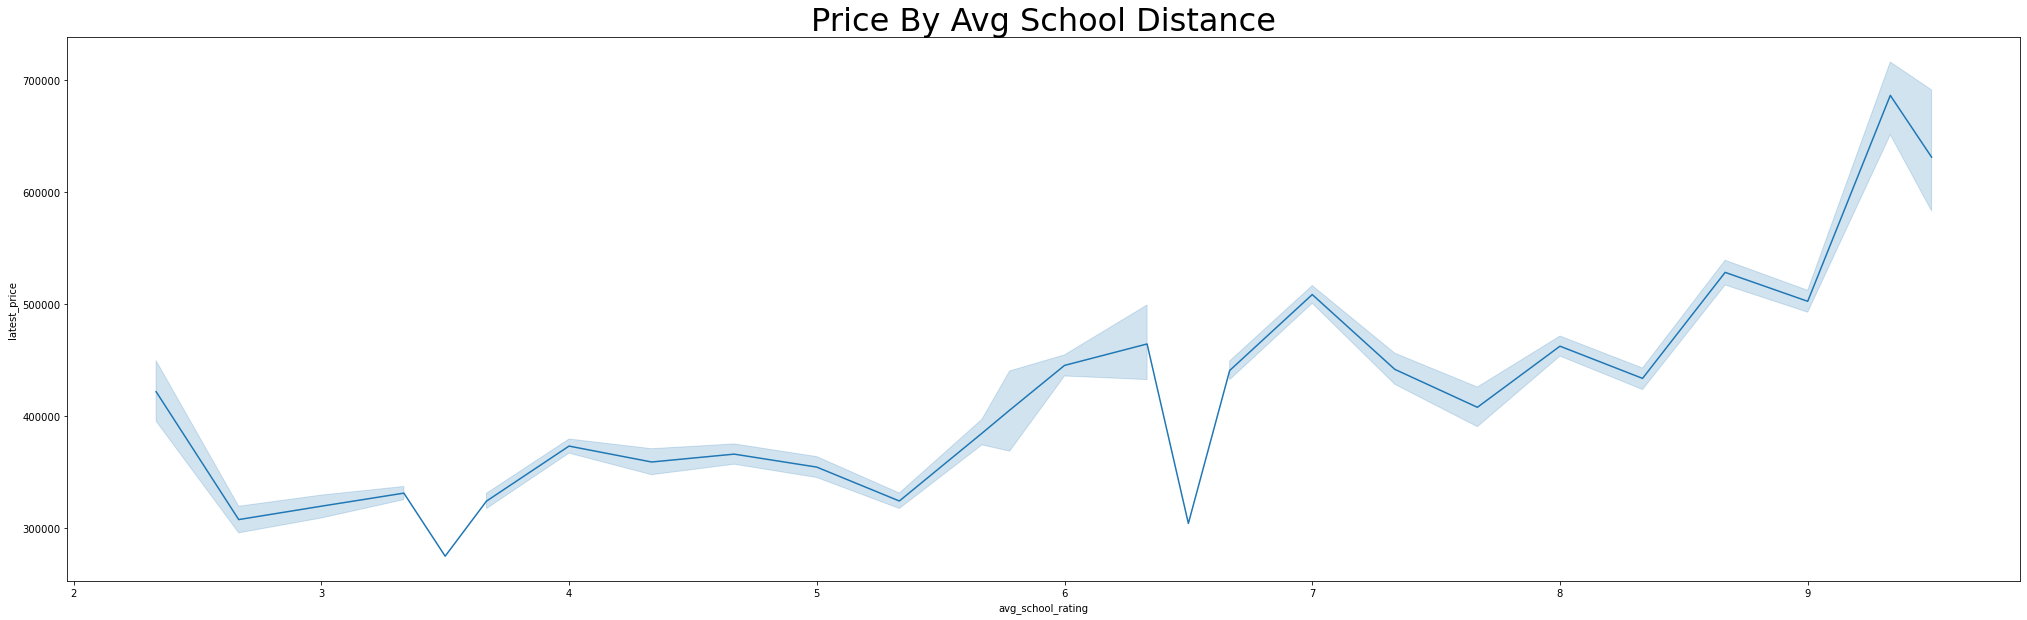

In [848]:
plt.figure(figsize=(35, 10))
plt.title("Price By Avg School Distance", fontsize=32)
sns.lineplot(data=austin_df, x="avg_school_rating", y="latest_price")


<AxesSubplot:title={'center':'Price By Avg School Size'}, xlabel='avg_school_size', ylabel='latest_price'>

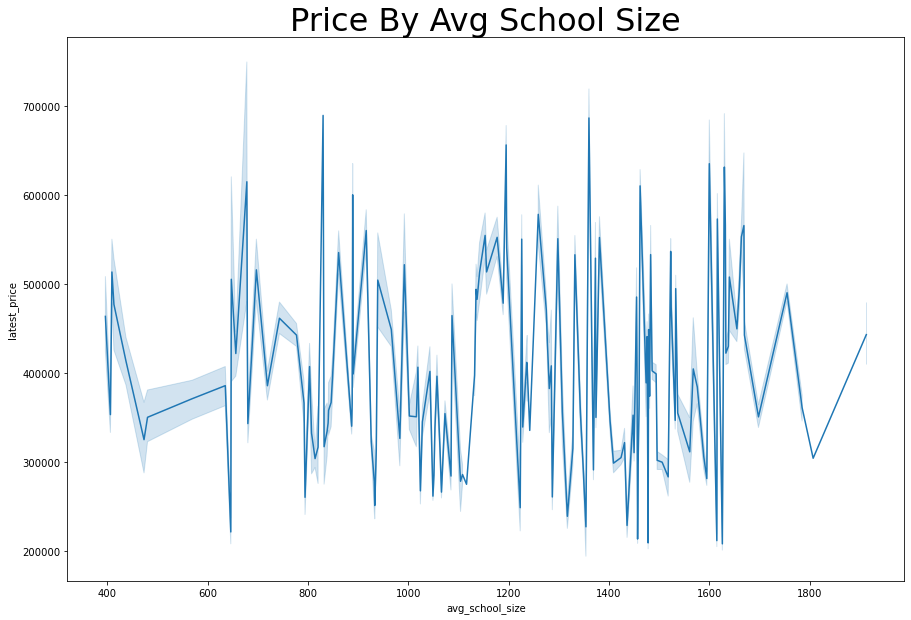

In [849]:
plt.figure(figsize=(15, 10))
plt.title("Price By Avg School Size", fontsize=32)
sns.lineplot(data=austin_df, x="avg_school_size", y="latest_price")


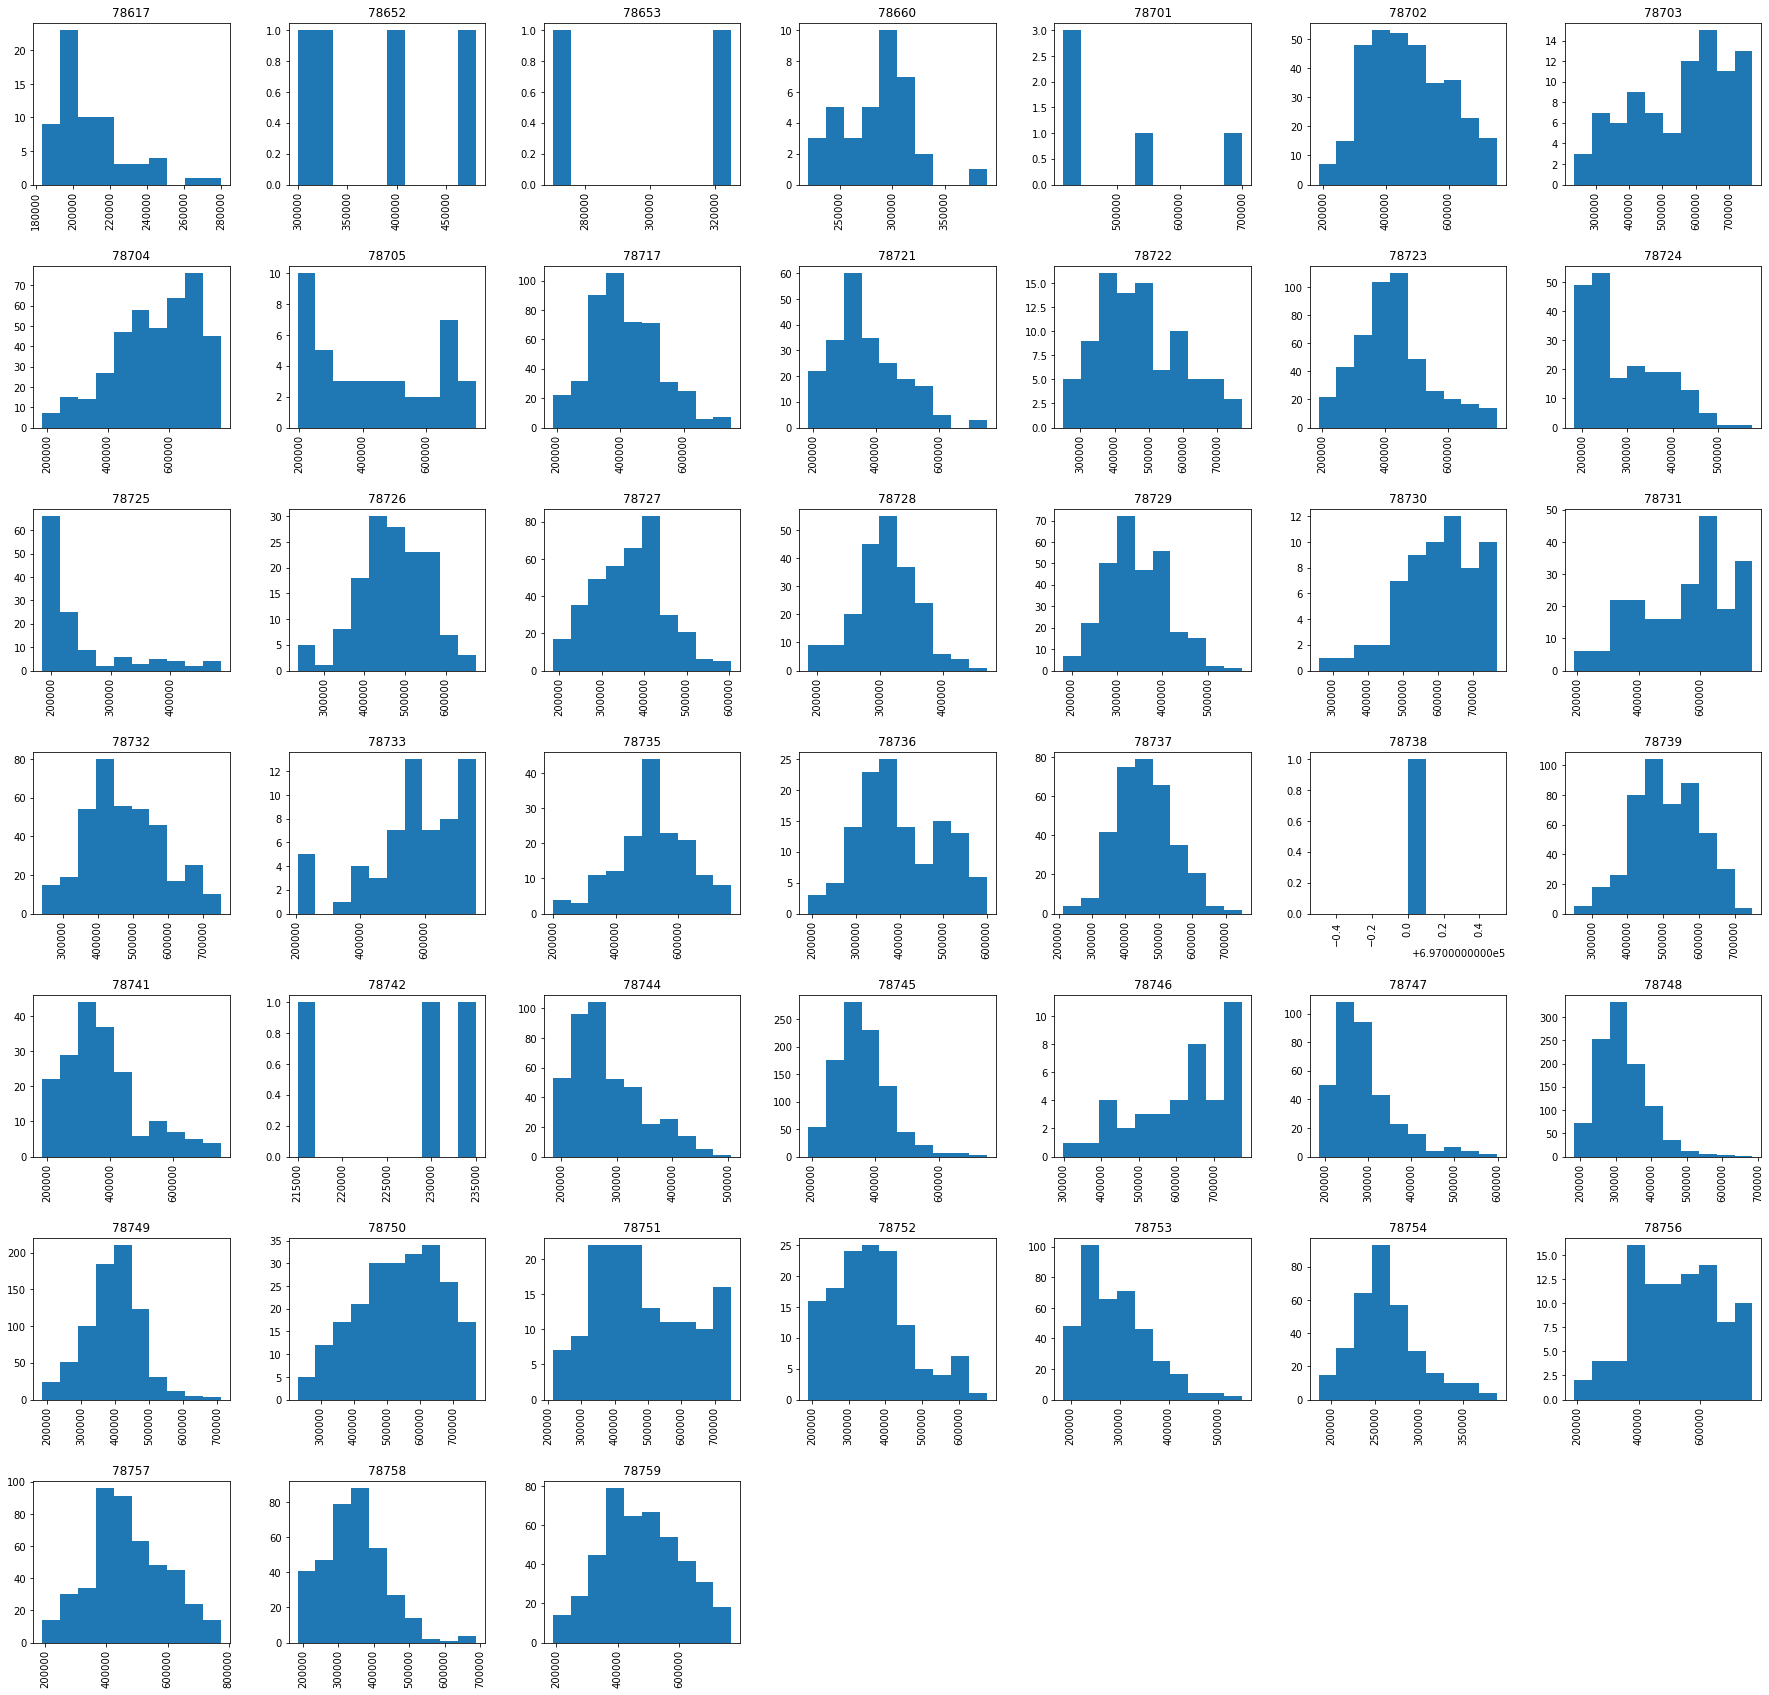

In [850]:
austin_df["latest_price"].hist(by=austin_df["zipcode"], figsize=(30, 30))


In [851]:
austin_df[["latitude", "longitude"]].head()


,latitude,longitude
0,30.430632,-97.663078
1,30.432673,-97.661697
2,30.409748,-97.639771
3,30.432112,-97.661659
4,30.437368,-97.656860


In [852]:
def cal_distance_miles(lat, long, coords_2):
    """Uses python geopy library to calculate distance between 2 coordinates

    Args:
        lat (float): latitude of given coordinate
        long (float): longitude of given coordinate

    Returns:
        _type_: distance between 2 coordinates
    """
    house_coords = (lat, long)
    return round(geopy.distance.geodesic(house_coords, coords_2).miles, 2)


def airport_distance(lat, long):
    austin_airport_coords = (30.1975, -97.6663058)
    return cal_distance_miles(lat, long, austin_airport_coords)


def downtown_distance(lat, long):
    austin_airport_coords = (30.266666, -97.733330)
    return cal_distance_miles(lat, long, austin_airport_coords)


In [853]:
austin_df["airport_distance"] = austin_df.apply(
    lambda x: airport_distance(x["latitude"], x["longitude"]), axis=1
)
austin_df["downtown_distance"] = austin_df.apply(
    lambda x: downtown_distance(x["latitude"], x["longitude"]), axis=1
)


<AxesSubplot:xlabel='airport_distance', ylabel='latest_price'>

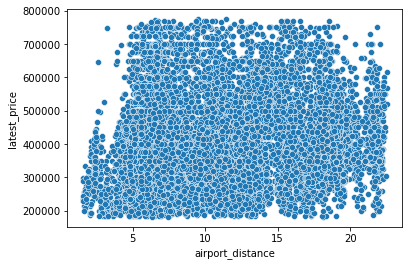

In [854]:
sns.scatterplot(data=austin_df, x="airport_distance", y="latest_price")


In [855]:
X = austin_df.drop(
    columns=[
        "latest_price",
        "zpid",
        "zipcode",
        "latitude",
        "longitude",
        "garage_spaces",
        "year_built",
        "_median_students_per_teacher",
        "downtown_distance",
        "latest_saleyear",
        "num_of_parking_features",
        "lot_size_sq_ft",
        "num_of_middle_schools",
        "num_of_primary_schools",
        "num_of_elementary_schools",
        "avg_school_size",
        "num_of_high_schools",
        "property_tax_rate",
        "parking_spaces",
        "avg_school_distance",
        "latest_salemonth",
        "num_price_changes",
    ]
)
X = X.select_dtypes(np.number)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)


                            feature        VIF
0                     num_of_photos   3.477149
1     num_of_accessibility_features   1.015758
2                 num_of_appliances   4.433590
3   num_of_patio_and_porch_features   2.161994
4          num_of_security_features   1.956387
5        num_of_waterfront_features   1.003519
6            num_of_window_features   1.458170
7         num_of_community_features   1.026151
8                 living_area_sq_ft  33.469978
9                 avg_school_rating  17.905576
10                 num_of_bathrooms  36.432563
11                  num_of_bedrooms  32.657132
12                   num_of_stories  15.083405
13                              age   3.939754
14                 airport_distance  12.592870


In [856]:
features = X.columns.tolist()


In [857]:
features.append("city")
features.append("home_type")
features.append("latest_price")


<AxesSubplot:>

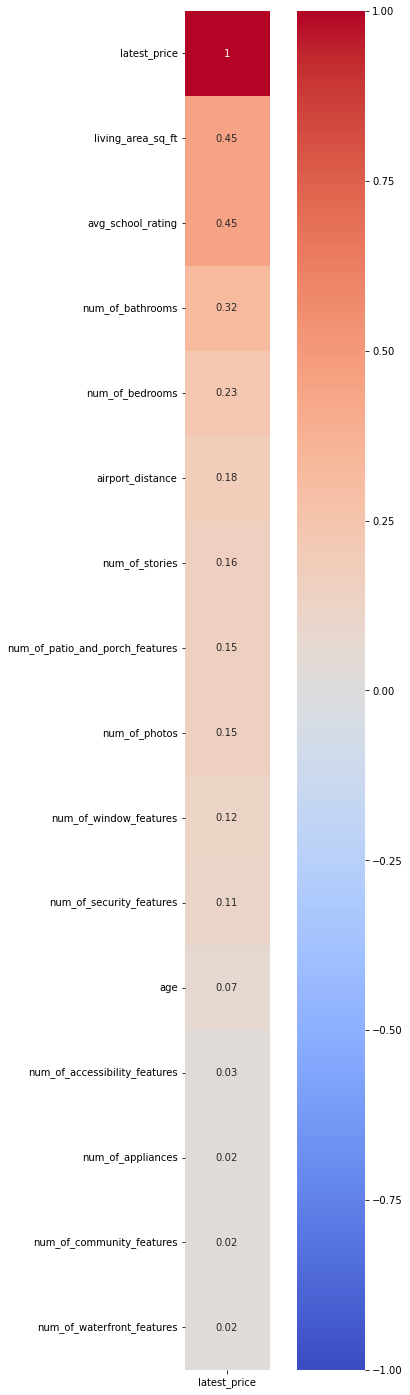

In [858]:
# Get feature price correlation after removing outliers
price_corr = (
    austin_df[features]
    .corr()[["latest_price"]]
    .sort_values(by="latest_price", ascending=False)
)

# Round correlation
corr = round(
    price_corr,
    2,
)

# Plot heatmap
plt.figure(figsize=(10, 25))
sns.heatmap(corr, square=True, cmap="coolwarm", annot=True, vmin=-1, vmax=1)


In [859]:
austin_df = austin_df[features]
austin_df.drop(
    columns=[
        "num_of_accessibility_features",
        "num_of_waterfront_features",
        "num_of_community_features",
        "num_of_appliances",
    ],
    inplace=True,
)


In [860]:
# Save preprocessed dataset
austin_df.to_csv("../../data/train.csv", index=False)
